In [84]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from scipy import stats
from IPython.display import display, HTML
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.model_selection import train_test_split
from datetime import datetime
from statsmodels.formula.api import ols
from statsmodels.stats.api import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import LabelEncoder
from scipy.stats import kruskal

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 3)
import warnings
warnings.filterwarnings('ignore')



In [85]:
#loading the dataset

df_trustpilot = pd.read_csv('data/data_trustpilot_3.csv', engine='python')
train_df = pd.read_csv('data/train_trustpilot_3.csv', engine='python')
test_df = pd.read_csv('data/test_trustpilot_3.csv', engine='python')

# Load TF-IDF matrices
X_train_tfidf = np.load('data/X_train_tfidf.npy')
X_test_tfidf = np.load('data/X_test_tfidf.npy')
tfidf_features = np.load('data/tfidf_features.npy', allow_pickle=True)

# Load BoW matrices
X_train_bow = np.load('data/X_train_bow.npy')
X_test_bow = np.load('data/X_test_bow.npy')
bow_features = np.load('data/bow_features.npy', allow_pickle=True)


print("Dataset shapes:")
print(f"Full dataset: {df_trustpilot.shape}")
print(f"Training set: {train_df.shape}")
print(f"Test set: {test_df.shape}")

print("Text feature matrices shapes:")
print(f"TF-IDF training: {X_train_tfidf.shape}")
print(f"TF-IDF testing: {X_test_tfidf.shape}")
print(f"BoW training: {X_train_bow.shape}")
print(f"BoW testing: {X_test_bow.shape}")

display(train_df.head())



Dataset shapes:
Full dataset: (64228, 34)
Training set: (51382, 34)
Test set: (12846, 34)
Text feature matrices shapes:
TF-IDF training: (51382, 5000)
TF-IDF testing: (12846, 5000)
BoW training: (51382, 5000)
BoW testing: (12846, 5000)


,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded
0,5,US,Paul D.,1,Verified,one-time,0,Flashbay,fast and efficient web site that allowed a simple interface to to upload my logo and choose my product. The whole process was quick and the product was of great quality.,fast efficient web site allowed simple interface upload logo choose product whole process quick product great quality,117,17,0.307,4.0,0.784,5,fast and efficient web site that…,fast efficient web site,23.0,4.0,"Hello Paul,That is Flashbay for you!Glad that you have found the ordering process easy, and are pleased with the final product.We appreciate your business, and look forward to working with you next time!-Flashbay Management",hello paulthat flashbay youglad found ordering process easy pleased final productwe appreciate business look forward working next timeflashbay management,1,2021-08-11,2021-08-11 17:03:19,2021-08-11,8,10,Business Hours,2,Business Day,0,quick_review,1
1,4,US,Tim Deutschle,1,Verified,one-time,0,Quicken,"I have used Quicken for many years, more than 30 years for sure. I find it difficult sometimes when adding accounts. Also, when entering CD’s and establishing a maturity schedule.",used quicken many years 30 years sure find difficult sometimes adding accounts also entering cds establishing maturity schedule,127,18,0.167,3.0,-0.052,3,I have used Quicken for many years,used quicken many years,23.0,4.0,0,0,0,2024-04-24,2024-05-01 16:23:54,2024-05-01,5,9,Business Hours,2,Business Day,0,late_review,0
2,1,GB,Matthew Hanshaw,2,Not Verified,repeat,1,Asda,A pile of s**t !!!!!!!!!!! Also you don’t even warrant a star had to select it to leave this review.,pile st also dont even warrant star select leave review,55,10,0.000,3.0,-0.052,3,A pile of s**t,pile st,7.0,2.0,0,0,0,2023-08-07,2023-08-08 21:16:55,2023-08-08,8,20,Evening,1,Business Day,0,late_review,0
3,2,US,Michael,1,Invited,one-time,0,Quicken,Not a super useful or intuitive tool. Better free options exist.,super useful intuitive tool better free options exist,53,8,0.383,4.0,0.919,5,Not a super useful or intuitive tool,super useful intuitive tool,27.0,4.0,0,0,0,2023-09-05,2023-09-05 18:27:02,2023-09-05,9,11,Business Hours,1,Business Day,0,quick_review,1
4,2,US,Alan,2,Invited,repeat,1,Quicken,not intuitive....poor guidelines and instructions on usage,intuitivepoor guidelines instructions usage,43,4,0.000,3.0,0.000,3,not intuitive....poor guidelines and…,intuitivepoor guidelines,24.0,2.0,0,0,0,2021-12-08,2021-12-08 02:43:54,2021-12-07,12,19,Evening,1,Business Day,0,quick_review,1


In [86]:
#First check
df_trustpilot['local_date_posted'] = pd.to_datetime(df_trustpilot['local_date_posted'])
df_trustpilot['date_of_experience'] = pd.to_datetime(df_trustpilot['date_of_experience'])
df_trustpilot['date_posted'] = pd.to_datetime(df_trustpilot['date_posted'])
print(df_trustpilot.columns)
display(df_trustpilot.info())

train_df['local_date_posted'] = pd.to_datetime(train_df['local_date_posted'])
train_df['date_of_experience'] = pd.to_datetime(train_df['date_of_experience'])
train_df['date_posted'] = pd.to_datetime(train_df['date_posted'])
print(train_df.columns)
display(train_df.info())

test_df['local_date_posted'] = pd.to_datetime(test_df['local_date_posted'])
test_df['date_of_experience'] = pd.to_datetime(test_df['date_of_experience'])
test_df['date_posted'] = pd.to_datetime(test_df['date_posted'])
print(test_df.columns)
display(test_df.info())

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64228 entries, 0 to 64227
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            64228 non-null  in

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51382 entries, 0 to 51381
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            51382 non-null  in

None

Index(['rating', 'location', 'username', 'number_reviews', 'verification',
       'repeat_reviewer', 'repeat_reviewer_encoded', 'company', 'text',
       'text_processed', 'text_length', 'text_word_length', 'Sentiment_Blob',
       'Sentiment_Blob_cat', 'Sentiment_VADER', 'Sentiment_VADER_cat',
       'subject', 'subject_processed', 'subject_length', 'subject_word_length',
       'answer', 'answer_processed', 'answered_encoded', 'date_of_experience',
       'date_posted', 'local_date_posted', 'month_local', 'local_hour',
       'time_of_day', 'day_of_week_posted', 'day_type',
       'days_between_experience_and_post', 'review_time',
       'review_time_encoded'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12846 entries, 0 to 12845
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            12846 non-null  in

None

STAGE 1 - HEATMAP & MULTICOLLINEARITY

In [87]:
# Split variables by type
binary_variables = ['repeat_reviewer', 'repeat_reviewer_encoded', 
    'answered_encoded', 'day_type', 
    'review_time', 'review_time_encoded']

categorical_text = ['location', 'username', 'verification', 'company',
    'text', 'text_processed', 'subject', 'subject_processed',
    'answer', 'answer_processed', 'time_of_day']

categorical_ordinal = ['rating', 
    'Sentiment_Blob_cat',  
    'Sentiment_VADER_cat']

true_numeric = ['number_reviews', 
    'text_length', 'text_word_length',
    'Sentiment_Blob',  # -1 to 1
    'Sentiment_VADER',  # -1 to 1
    'subject_length', 'subject_word_length',
    'days_between_experience_and_post']

time_based_numeric = ['month_local',  # 1-12
    'local_hour',   # 0-23
    'day_of_week_posted']

datetime_columns = ['date_of_experience',
    'date_posted',
    'local_date_posted']

# Create DataFrame with numeric and ordinal features for correlation analysis
numeric_for_correlation = train_df[true_numeric + categorical_ordinal + 
                                 time_based_numeric].copy()


# Create DataFrame with TF-IDF features
tfidf_df = pd.DataFrame(X_train_tfidf, columns=[f'tfidf_{i}' 
                       for i in range(X_train_tfidf.shape[1])])
top_n_tfidf = 5
top_tfidf_cols = tfidf_df.var().nlargest(top_n_tfidf).index

# Create DataFrame with BoW features
bow_df = pd.DataFrame(X_train_bow, columns=[f'bow_{i}' 
                     for i in range(X_train_bow.shape[1])])
top_n_bow = 5
top_bow_cols = bow_df.var().nlargest(top_n_bow).index



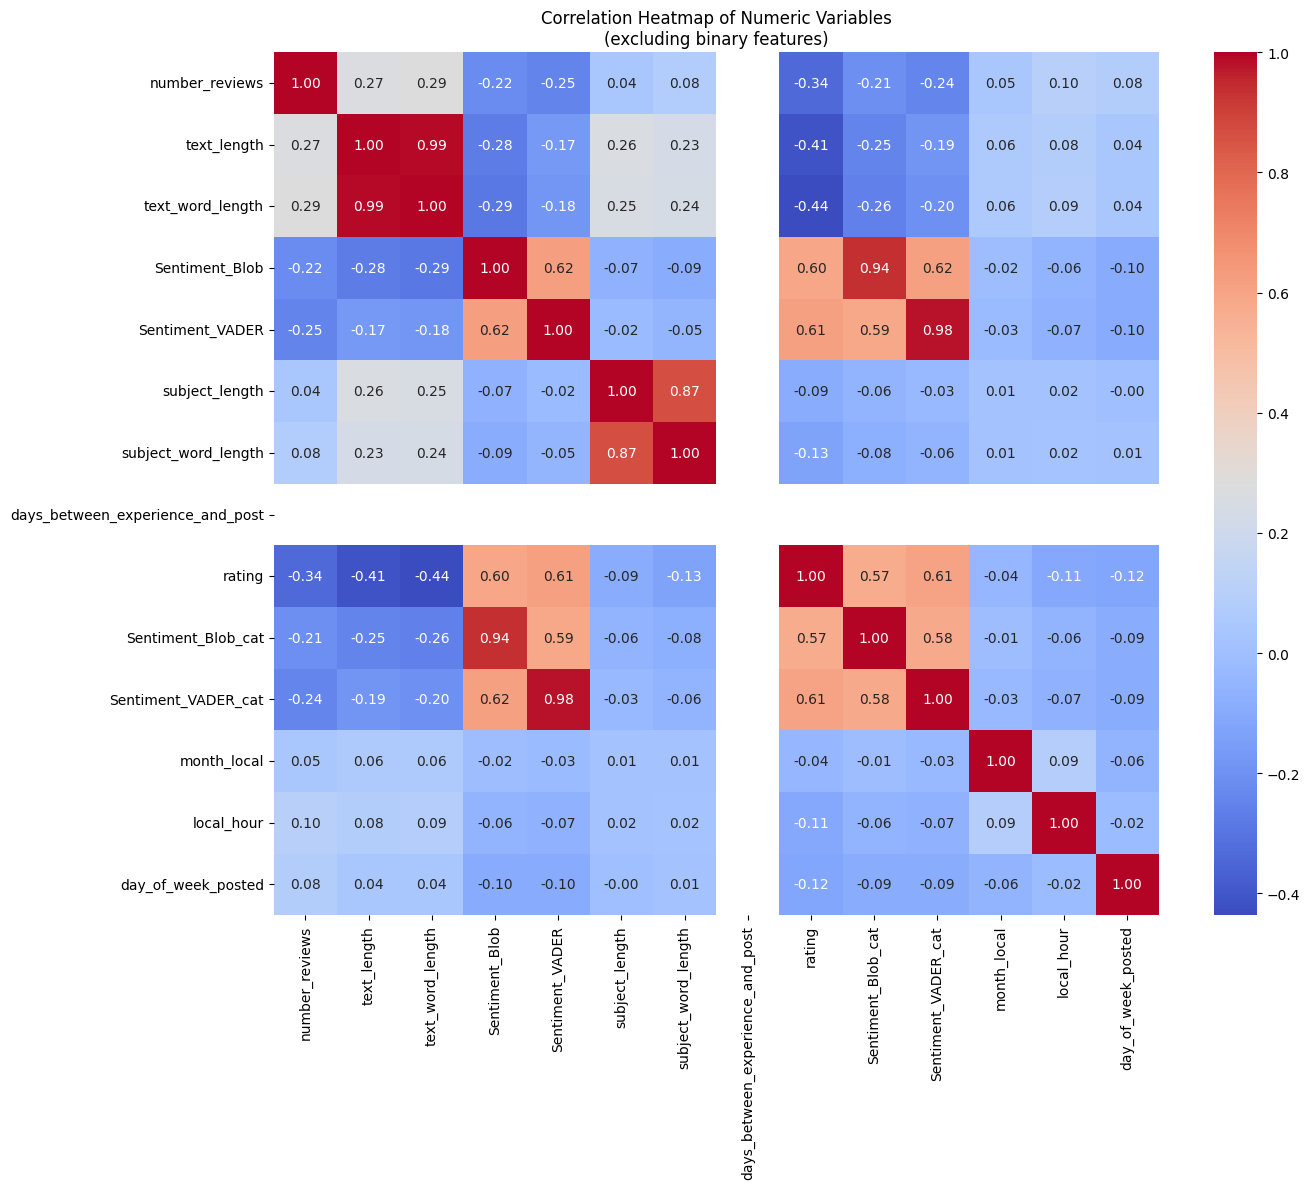

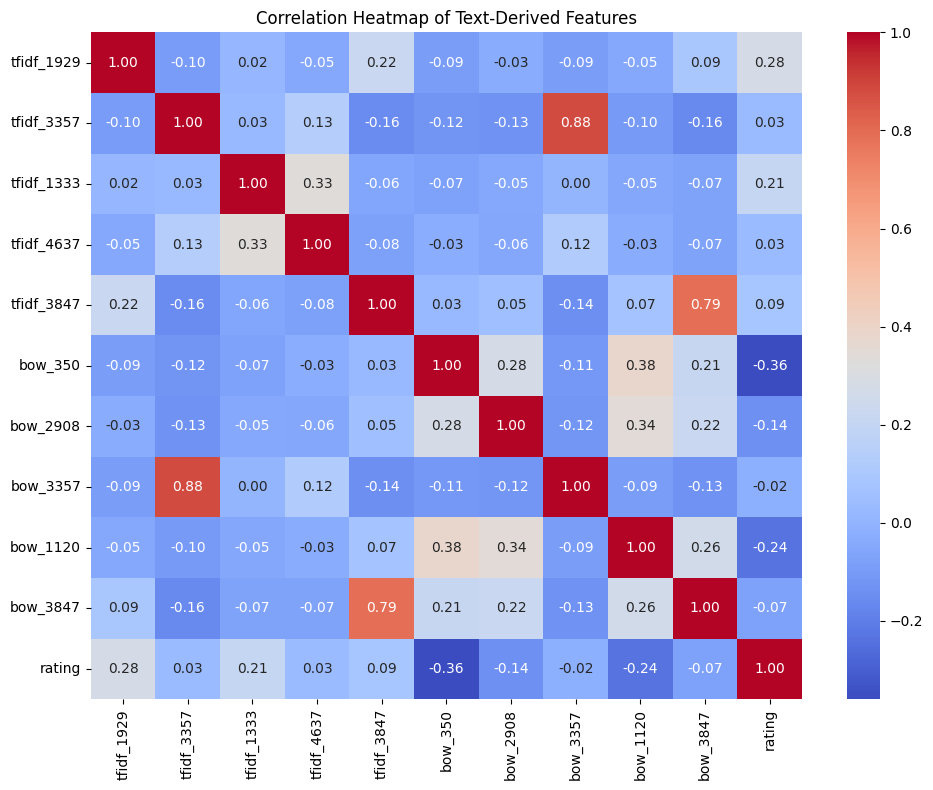

Highly correlated pairs (>0.7) with analysis:

Original Numeric Variables:

text_word_length & text_length: 0.994
Correlation with rating: text_word_length: 0.436, text_length: 0.413
Recommendation: Keep text_word_length (stronger correlation with target)

subject_word_length & subject_length: 0.870
Correlation with rating: subject_word_length: 0.131, subject_length: 0.090
Recommendation: Keep subject_word_length (stronger correlation with target)

Sentiment_Blob_cat & Sentiment_Blob: 0.936
Correlation with rating: Sentiment_Blob_cat: 0.568, Sentiment_Blob: 0.596
Recommendation: Keep Sentiment_Blob (stronger correlation with target)

Sentiment_VADER_cat & Sentiment_VADER: 0.982
Correlation with rating: Sentiment_VADER_cat: 0.605, Sentiment_VADER: 0.613
Recommendation: Keep Sentiment_VADER (stronger correlation with target)

Text-Derived Features:

bow_3357 & tfidf_3357: 0.880
Correlation with rating: bow_3357: 0.016, tfidf_3357: 0.028
Recommendation: Keep tfidf_3357 (stronger correlati

In [88]:
# Correlation heatmaps
# 1. True numeric and ordinal variables
original_corr = numeric_for_correlation.corr()
plt.figure(figsize=(14, 12))
sns.heatmap(original_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Variables\n(excluding binary features)')
plt.tight_layout()
plt.show()

# 2. Text-derived features
text_features_with_rating = pd.concat([
    tfidf_df[top_tfidf_cols],
    bow_df[top_bow_cols],
    train_df['rating']
], axis=1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(text_features_with_rating, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Text-Derived Features')
plt.tight_layout()
plt.show()

# Analyze correlations and print results
print("Highly correlated pairs (>0.7) with analysis:")
print("\nOriginal Numeric Variables:")
for i in range(len(original_corr.columns)):
    for j in range(i):
        if abs(original_corr.iloc[i, j]) > 0.7:
            var1 = original_corr.columns[i]
            var2 = original_corr.columns[j]
            correlation = original_corr.iloc[i, j]
            corr_with_target1 = abs(original_corr.loc[var1, 'rating'])
            corr_with_target2 = abs(original_corr.loc[var2, 'rating'])
            print(f"\n{var1} & {var2}: {correlation:.3f}")
            print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, "
                  f"{var2}: {corr_with_target2:.3f}")
            print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                  f"(stronger correlation with target)")

print("\nText-Derived Features:")
for i in range(len(text_features_with_rating.columns)):
    for j in range(i):
        if abs(text_features_with_rating.iloc[i, j]) > 0.7:
            var1 = text_features_with_rating.columns[i]
            var2 = text_features_with_rating.columns[j]
            if var1 != 'rating' and var2 != 'rating':
                correlation = text_features_with_rating.iloc[i, j]
                corr_with_target1 = abs(text_features_with_rating.loc[var1, 'rating'])
                corr_with_target2 = abs(text_features_with_rating.loc[var2, 'rating'])
                print(f"\n{var1} & {var2}: {correlation:.3f}")
                print(f"Correlation with rating: {var1}: {corr_with_target1:.3f}, "
                      f"{var2}: {corr_with_target2:.3f}")
                print(f"Recommendation: Keep {var1 if corr_with_target1 > corr_with_target2 else var2} "
                      f"(stronger correlation with target)")

# Print note about binary variables
print("\nNote: Binary variables were excluded from correlation analysis as they require "
      "different statistical approaches (e.g., point-biserial correlation).")

STAGE 2 - PEARSON AND SPEARMAN

In [89]:
def analyze_correlation_with_rating(column_name, data, var_type):
    # Skip correlation for binary variables
    if column_name in binary_variables:
        return None
    
    # For ordinal and numeric variables
    if var_type in ['ordinal', 'numeric', 'time_numeric']:
        pearson_coeff, pearson_p = pearsonr(data['rating'], data[column_name])
        spearman_coeff, spearman_p = spearmanr(data['rating'], data[column_name])
        
        def get_strength(coeff):
            if abs(coeff) < 0.1: return "extremely weak/negligible"
            elif abs(coeff) < 0.3: return "weak"
            elif abs(coeff) < 0.5: return "moderate"
            else: return "strong"
        
        pearson_strength = get_strength(pearson_coeff)
        spearman_strength = get_strength(spearman_coeff)
        direction = "negative" if pearson_coeff < 0 else "positive"
        
        output = [
            f"\nCorrelation Analysis: rating vs {column_name} ({var_type})",
            "=" * 50,
            f"Pearson: {pearson_coeff:.3f} (p={pearson_p:.3e}) - {pearson_strength} {direction}",
            f"Spearman: {spearman_coeff:.3f} (p={spearman_p:.3e}) - {spearman_strength}",
            f"Conclusion: {'Significant' if (pearson_p < 0.05 or spearman_p < 0.05) else 'Not significant'}"
        ]
        
        return "\n".join(output), pearson_coeff, pearson_p, spearman_coeff, spearman_p
    
    return None

# Combine text features and rating
text_features_df = pd.concat([
    tfidf_df[top_tfidf_cols],
    bow_df[top_bow_cols],
    train_df['rating']
], axis=1)

# Analyze by variable type
print("True Numeric Variables:")
for column in true_numeric:
    result = analyze_correlation_with_rating(column, train_df, 'numeric')
    if result:
        print(result[0])

print("\nTime-based Numeric Variables:")
for column in time_based_numeric:
    result = analyze_correlation_with_rating(column, train_df, 'time_numeric')
    if result:
        print(result[0])

print("\nOrdinal Variables:")
for column in categorical_ordinal:
    if column != 'rating':
        result = analyze_correlation_with_rating(column, train_df, 'ordinal')
        if result:
            print(result[0])

print("\nText-Derived Features:")
all_text_columns = list(top_tfidf_cols) + list(top_bow_cols)
for column in all_text_columns:
    result = analyze_correlation_with_rating(column, text_features_df, 'numeric')
    if result:
        print(result[0])

# Create summary of findings
feature_summary = []
print("\nFEATURE SELECTION SUMMARY")
print("=" * 80)

# Process all variable types
for column, var_type in (
    [(col, 'numeric') for col in true_numeric] +
    [(col, 'time_numeric') for col in time_based_numeric] +
    [(col, 'ordinal') for col in categorical_ordinal if col != 'rating'] +
    [(col, 'text_derived') for col in all_text_columns]
):
    data = train_df if column not in all_text_columns else text_features_df
    result = analyze_correlation_with_rating(column, data, var_type)
    
    if result and (result[2] < 0.05 or result[4] < 0.05):  # If significant
        strength = max(abs(result[1]), abs(result[3]))  # Max of Pearson/Spearman
        feature_summary.append({
            'feature': column,
            'strength': strength,
            'type': var_type,
            'significant': 'Yes'
        })

# Display sorted summary
summary_df = pd.DataFrame(feature_summary)
summary_df = summary_df.sort_values('strength', ascending=False)
print("\nRecommended features to keep (statistically significant):")
display(summary_df)

print("\nNote: Binary variables excluded from correlation analysis as they require different statistical approaches.")

True Numeric Variables:

Correlation Analysis: rating vs number_reviews (numeric)
Pearson: -0.336 (p=0.000e+00) - moderate negative
Spearman: -0.302 (p=0.000e+00) - moderate
Conclusion: Significant

Correlation Analysis: rating vs text_length (numeric)
Pearson: -0.413 (p=0.000e+00) - moderate negative
Spearman: -0.375 (p=0.000e+00) - moderate
Conclusion: Significant

Correlation Analysis: rating vs text_word_length (numeric)
Pearson: -0.436 (p=0.000e+00) - moderate negative
Spearman: -0.396 (p=0.000e+00) - moderate
Conclusion: Significant

Correlation Analysis: rating vs Sentiment_Blob (numeric)
Pearson: 0.596 (p=0.000e+00) - strong positive
Spearman: 0.634 (p=0.000e+00) - strong
Conclusion: Significant

Correlation Analysis: rating vs Sentiment_VADER (numeric)
Pearson: 0.613 (p=0.000e+00) - strong positive
Spearman: 0.588 (p=0.000e+00) - strong
Conclusion: Significant

Correlation Analysis: rating vs subject_length (numeric)
Pearson: -0.090 (p=1.049e-92) - extremely weak/negligible ne

,feature,strength,type,significant
3,Sentiment_Blob,0.634,numeric,Yes
4,Sentiment_VADER,0.613,numeric,Yes
11,Sentiment_VADER_cat,0.605,ordinal,Yes
10,Sentiment_Blob_cat,0.597,ordinal,Yes
2,text_word_length,0.436,numeric,Yes
1,text_length,0.413,numeric,Yes
0,number_reviews,0.336,numeric,Yes
6,subject_word_length,0.131,numeric,Yes
9,day_of_week_posted,0.116,time_numeric,Yes
8,local_hour,0.106,time_numeric,Yes



Note: Binary variables excluded from correlation analysis as they require different statistical approaches.


STAGE 3 - MUTUAL INFORMATION

In [90]:
def analyze_mutual_information_with_rating(column_name, data, var_type):
   # For binary variables, ensure they're numeric
   feature_data = data[column_name]
   if var_type == 'binary':
       if feature_data.dtype == 'object':  # If string values
           # Use the encoded version if available
           encoded_col = column_name + '_encoded'
           if encoded_col in data.columns:
               feature_data = data[encoded_col]
           else:
               return None  # Skip if no encoded version available
   
   # Calculate mutual information
   mi_score = mutual_info_regression(feature_data.values.reshape(-1, 1), 
                                   data['rating'], 
                                   random_state=42)[0]
   
   # Different thresholds based on variable type
   def get_strength(score, var_type):
       if var_type == 'binary':
           if score < 0.005: return "extremely weak/negligible"
           elif score < 0.02: return "weak"
           elif score < 0.1: return "moderate"
           else: return "strong"
       else:  # numeric, ordinal, time_based
           if score < 0.01: return "extremely weak/negligible"
           elif score < 0.05: return "weak"
           elif score < 0.2: return "moderate"
           else: return "strong"
   
   strength = get_strength(mi_score, var_type)
   
   output = [
       f"\nMutual Information Analysis: rating vs {column_name} ({var_type})",
       "=" * 50,
       f"MI Score: {mi_score:.4f} - {strength}",
       f"Recommendation: {'Keep' if (mi_score > 0.01 and var_type != 'binary') or (mi_score > 0.005 and var_type == 'binary') else 'Consider dropping'}"
   ]
   return "\n".join(output), mi_score, strength

# Store results for summary
results = []

# Analyze true numeric variables
print("\nTrue Numeric Variables:")
for column in true_numeric:
   output, mi_score, strength = analyze_mutual_information_with_rating(column, train_df, 'numeric')
   print(output)
   results.append({
       'feature': column,
       'mi_score': mi_score,
       'strength': strength,
       'type': 'Numeric'
   })

# Analyze time-based numeric variables
print("\nTime-based Numeric Variables:")
for column in time_based_numeric:
   output, mi_score, strength = analyze_mutual_information_with_rating(column, train_df, 'time_numeric')
   print(output)
   results.append({
       'feature': column,
       'mi_score': mi_score,
       'strength': strength,
       'type': 'Time-based'
   })

# Analyze ordinal variables
print("\nOrdinal Variables:")
for column in categorical_ordinal:
   if column != 'rating':
       output, mi_score, strength = analyze_mutual_information_with_rating(column, train_df, 'ordinal')
       print(output)
       results.append({
           'feature': column,
           'mi_score': mi_score,
           'strength': strength,
           'type': 'Ordinal'
       })

# Analyze binary variables
print("\nBinary Variables:")
for column in binary_variables:
   # Skip non-encoded string binary variables
   if column.endswith('_encoded') or train_df[column].dtype in ['int64', 'float64']:
       output, mi_score, strength = analyze_mutual_information_with_rating(column, train_df, 'binary')
       if output:  # If analysis was successful
           print(output)
           results.append({
               'feature': column,
               'mi_score': mi_score,
               'strength': strength,
               'type': 'Binary'
           })

# Analyze text-derived features
print("\nText-Derived Features:")
text_features_df = pd.concat([
   tfidf_df[top_tfidf_cols],
   bow_df[top_bow_cols],
   train_df['rating']
], axis=1)

for column in list(top_tfidf_cols) + list(top_bow_cols):
   output, mi_score, strength = analyze_mutual_information_with_rating(column, text_features_df, 'numeric')
   print(output)
   results.append({
       'feature': column,
       'mi_score': mi_score,
       'strength': strength,
       'type': 'Text-derived'
   })

# Create summary DataFrame
summary_df = pd.DataFrame(results)
summary_df = summary_df.sort_values('mi_score', ascending=False)

print("\nFEATURE SELECTION SUMMARY")
print("=" * 80)
print("\nTop features by mutual information score:")
display(summary_df)

# Print recommended features to keep with type-specific thresholds
print("\nRecommended features to keep:")
recommended_df = summary_df[
   ((summary_df['type'] != 'Binary') & (summary_df['mi_score'] > 0.01)) |
   ((summary_df['type'] == 'Binary') & (summary_df['mi_score'] > 0.005))
].sort_values('mi_score', ascending=False)
display(recommended_df)


True Numeric Variables:

Mutual Information Analysis: rating vs number_reviews (numeric)
MI Score: 0.0653 - moderate
Recommendation: Keep

Mutual Information Analysis: rating vs text_length (numeric)
MI Score: 0.0869 - moderate
Recommendation: Keep

Mutual Information Analysis: rating vs text_word_length (numeric)
MI Score: 0.1003 - moderate
Recommendation: Keep

Mutual Information Analysis: rating vs Sentiment_Blob (numeric)
MI Score: 0.2857 - strong
Recommendation: Keep

Mutual Information Analysis: rating vs Sentiment_VADER (numeric)
MI Score: 0.2594 - strong
Recommendation: Keep

Mutual Information Analysis: rating vs subject_length (numeric)
MI Score: 0.0131 - weak
Recommendation: Keep

Mutual Information Analysis: rating vs subject_word_length (numeric)
MI Score: 0.0109 - weak
Recommendation: Keep

Mutual Information Analysis: rating vs days_between_experience_and_post (numeric)
MI Score: 0.0006 - extremely weak/negligible
Recommendation: Consider dropping

Time-based Numeric Va

,feature,mi_score,strength,type
3,Sentiment_Blob,2.857e-01,strong,Numeric
4,Sentiment_VADER,2.594e-01,strong,Numeric
11,Sentiment_Blob_cat,2.129e-01,strong,Ordinal
12,Sentiment_VADER_cat,2.103e-01,strong,Ordinal
14,answered_encoded,1.195e-01,strong,Binary
21,bow_350,1.103e-01,moderate,Text-derived
2,text_word_length,1.003e-01,moderate,Numeric
1,text_length,8.686e-02,moderate,Numeric
0,number_reviews,6.529e-02,moderate,Numeric
16,tfidf_1929,6.525e-02,moderate,Text-derived



Recommended features to keep:


,feature,mi_score,strength,type
3,Sentiment_Blob,0.286,strong,Numeric
4,Sentiment_VADER,0.259,strong,Numeric
11,Sentiment_Blob_cat,0.213,strong,Ordinal
12,Sentiment_VADER_cat,0.210,strong,Ordinal
14,answered_encoded,0.120,strong,Binary
21,bow_350,0.110,moderate,Text-derived
2,text_word_length,0.100,moderate,Numeric
1,text_length,0.087,moderate,Numeric
0,number_reviews,0.065,moderate,Numeric
16,tfidf_1929,0.065,moderate,Text-derived


STAGE 4 - ANOVA

In [91]:
def analyze_anova_with_rating(feature_name, data):
    try:
        lm = ols('rating ~ {}'.format(feature_name), data=data).fit()
        table = anova_lm(lm)
        p_value = table['PR(>F)'].iloc[0]
        f_stat = table['F'].iloc[0]
        
        ss_between = table['sum_sq'][0]
        ss_total = ss_between + table['sum_sq'][1]
        eta_squared = ss_between / ss_total
        
        effect_strength = ("negligible" if eta_squared < 0.01 else
                         "small" if eta_squared < 0.06 else
                         "medium" if eta_squared < 0.14 else
                         "large")
        
        return {
            'p_value': p_value,
            'f_stat': f_stat,
            'eta_squared': eta_squared,
            'effect_strength': effect_strength,
            'significant': p_value <= 0.05
        }
    except Exception as e:
        print(f"Error analyzing {feature_name}: {str(e)}")
        return None

def run_anova_analysis(train_df, tfidf_df, bow_df, top_tfidf_cols, top_bow_cols):
    # Prepare numeric features
    numeric_features = (true_numeric + time_based_numeric + 
                       [col for col in binary_variables if col.endswith('_encoded')])
    
    # Prepare categorical features that need encoding
    le = LabelEncoder()
    categorical_encoded = {}
    for col in ['verification', 'time_of_day']:
        categorical_encoded[col] = le.fit_transform(train_df[col])
    
    # Combine all features
    text_derived_numeric = ['Sentiment_Blob', 'Sentiment_VADER', 'text_length', 
                           'text_word_length', 'subject_length', 'subject_word_length']
    sentiment_categorical = ['Sentiment_Blob_cat', 'Sentiment_VADER_cat']
    
    # Create analysis DataFrame
    analysis_df = pd.DataFrame()
    
    # Add numeric features
    for col in numeric_features:
        if col in train_df.columns:
            analysis_df[col] = train_df[col]
    
    # Add encoded categorical features
    for col, encoded_vals in categorical_encoded.items():
        analysis_df[col] = encoded_vals
    
    # Add sentiment features
    for col in text_derived_numeric + sentiment_categorical:
        if col in train_df.columns:
            analysis_df[col] = train_df[col]
    
    # Add text-derived features
    if len(top_tfidf_cols) > 0:
        analysis_df = pd.concat([analysis_df, tfidf_df[top_tfidf_cols]], axis=1)
    if len(top_bow_cols) > 0:
        analysis_df = pd.concat([analysis_df, bow_df[top_bow_cols]], axis=1)
    
    # Add target
    analysis_df['rating'] = train_df['rating']
    
    # Run ANOVA
    results = {}
    for column in analysis_df.columns:
        if column != 'rating':
            stats = analyze_anova_with_rating(column, analysis_df)
            if stats:
                results[column] = stats
    
    # Create summary DataFrame
    summary_df = pd.DataFrame.from_dict(results, orient='index')
    summary_df['feature'] = summary_df.index
    summary_df = summary_df.sort_values('eta_squared', ascending=False)
    
    # Display results
    print("\nANOVA Analysis Summary:")
    print(f"Total features analyzed: {len(results)}")
    print(f"Significant features: {len(summary_df[summary_df['significant']])}")
    
    print("\nFeature Selection Summary (sorted by effect size):")
    display(summary_df)
    
    print("\nRecommended features (p ≤ 0.05 and effect size > 0.01):")
    recommended_df = summary_df[
        (summary_df['significant']) & 
        (summary_df['eta_squared'] > 0.01)
    ].sort_values('eta_squared', ascending=False)
    display(recommended_df)
    
    return summary_df, recommended_df

# Run the analysis
summary_df, recommended_df = run_anova_analysis(
    train_df, tfidf_df, bow_df, top_tfidf_cols, top_bow_cols
)


ANOVA Analysis Summary:
Total features analyzed: 28
Significant features: 27

Feature Selection Summary (sorted by effect size):


,p_value,f_stat,eta_squared,effect_strength,significant,feature
Sentiment_VADER,0.000e+00,30954.931,3.760e-01,large,True,Sentiment_VADER
Sentiment_VADER_cat,0.000e+00,29700.381,3.663e-01,large,True,Sentiment_VADER_cat
Sentiment_Blob,0.000e+00,28305.914,3.552e-01,large,True,Sentiment_Blob
Sentiment_Blob_cat,0.000e+00,24530.981,3.232e-01,large,True,Sentiment_Blob_cat
text_word_length,0.000e+00,12077.453,1.903e-01,large,True,text_word_length
text_length,0.000e+00,10546.869,1.703e-01,large,True,text_length
answered_encoded,0.000e+00,9500.691,1.561e-01,large,True,answered_encoded
bow_350,0.000e+00,7629.551,1.293e-01,medium,True,bow_350
number_reviews,0.000e+00,6552.780,1.131e-01,medium,True,number_reviews
verification,0.000e+00,5871.173,1.026e-01,medium,True,verification



Recommended features (p ≤ 0.05 and effect size > 0.01):


,p_value,f_stat,eta_squared,effect_strength,significant,feature
Sentiment_VADER,0.000e+00,30954.931,0.376,large,True,Sentiment_VADER
Sentiment_VADER_cat,0.000e+00,29700.381,0.366,large,True,Sentiment_VADER_cat
Sentiment_Blob,0.000e+00,28305.914,0.355,large,True,Sentiment_Blob
Sentiment_Blob_cat,0.000e+00,24530.981,0.323,large,True,Sentiment_Blob_cat
text_word_length,0.000e+00,12077.453,0.190,large,True,text_word_length
text_length,0.000e+00,10546.869,0.170,large,True,text_length
answered_encoded,0.000e+00,9500.691,0.156,large,True,answered_encoded
bow_350,0.000e+00,7629.551,0.129,medium,True,bow_350
number_reviews,0.000e+00,6552.780,0.113,medium,True,number_reviews
verification,0.000e+00,5871.173,0.103,medium,True,verification


STAGE 5 - VARIANCE THRESHOLD

In [92]:
def analyze_variance_threshold(threshold=0.01):
    """
    Analyze feature variance for feature selection
    """
    # Collect features by type
    numeric_features = true_numeric + time_based_numeric
    binary_features = [col for col in binary_variables if col.endswith('_encoded')]
    sentiment_features = ['Sentiment_Blob', 'Sentiment_VADER', 'Sentiment_Blob_cat', 'Sentiment_VADER_cat']
    text_metrics = ['text_length', 'text_word_length', 'subject_length', 'subject_word_length']
    
    # Initialize results
    results = []
    
    # Process numeric features
    for feature in numeric_features:
        if feature in train_df.columns:
            var = train_df[feature].var()
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'Numeric',
                'low_variance': var <= threshold
            })
    
    # Process binary features (different threshold for binary)
    binary_threshold = 0.05  # Higher threshold for binary features
    for feature in binary_features:
        if feature in train_df.columns:
            var = train_df[feature].var()
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'Binary',
                'low_variance': var <= binary_threshold
            })
    
    # Process sentiment features
    for feature in sentiment_features:
        if feature in train_df.columns:
            var = train_df[feature].var()
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'Sentiment',
                'low_variance': var <= threshold
            })
    
    # Process text metrics
    for feature in text_metrics:
        if feature in train_df.columns:
            var = train_df[feature].var()
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'Text-Metric',
                'low_variance': var <= threshold
            })
    
    # Process TF-IDF features if available
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        for feature in top_tfidf_cols:
            var = tfidf_df[feature].var()
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'TF-IDF',
                'low_variance': var <= threshold
            })
    
    # Process BoW features if available
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        for feature in top_bow_cols:
            var = bow_df[feature].var()
            results.append({
                'feature': feature,
                'variance': var,
                'type': 'BoW',
                'low_variance': var <= threshold
            })
    
    # Create summary DataFrame
    results_df = pd.DataFrame(results).sort_values('variance', ascending=False)
    
    # Display results
    print("Variance Threshold Analysis")
    print("=" * 50)
    print(f"\nFeatures analyzed: {len(results_df)}")
    print(f"Low variance features: {sum(results_df['low_variance'])}")
    
    # Group by feature type
    print("\nAnalysis by Feature Type:")
    type_summary = results_df.groupby('type').agg({
        'feature': 'count',
        'low_variance': 'sum'
    }).rename(columns={'feature': 'total_features', 'low_variance': 'low_variance_features'})
    display(type_summary)
    
    # Display recommendations
    print("\nRecommendations:")
    keep_df = results_df[~results_df['low_variance']].sort_values(['type', 'variance'], ascending=[True, False])
    drop_df = results_df[results_df['low_variance']].sort_values(['type', 'variance'], ascending=[True, False])
    
    print("\nFeatures to keep:")
    display(keep_df)
    
    if not drop_df.empty:
        print("\nConsider dropping these features:")
        display(drop_df)
    
    return results_df

# Run the analysis
variance_results = analyze_variance_threshold(threshold=0.01)

Variance Threshold Analysis

Features analyzed: 32
Low variance features: 6

Analysis by Feature Type:


,total_features,low_variance_features
type,,
Binary,3,0
BoW,5,0
Numeric,11,1
Sentiment,4,0
TF-IDF,5,5
Text-Metric,4,0



Recommendations:

Features to keep:


,feature,variance,type,low_variance
11,repeat_reviewer_encoded,0.246,Binary,False
12,answered_encoded,0.187,Binary,False
13,review_time_encoded,0.162,Binary,False
27,bow_350,0.607,BoW,False
28,bow_2908,0.487,BoW,False
29,bow_3357,0.426,BoW,False
30,bow_1120,0.402,BoW,False
31,bow_3847,0.346,BoW,False
1,text_length,17020.529,Numeric,False
2,text_word_length,364.044,Numeric,False



Consider dropping these features:


,feature,variance,type,low_variance
7,days_between_experience_and_post,0.000,Numeric,True
22,tfidf_1929,0.004,TF-IDF,True
23,tfidf_3357,0.004,TF-IDF,True
24,tfidf_1333,0.004,TF-IDF,True
25,tfidf_4637,0.003,TF-IDF,True
26,tfidf_3847,0.003,TF-IDF,True


STAGE 6 - FISHER SCORE

In [93]:
def calculate_fisher_score(feature_data, target):
    """Calculate Fisher score for a feature"""
    class_stats = pd.DataFrame({
        'mean': feature_data.groupby(target).mean(),
        'var': feature_data.groupby(target).var(),
        'count': feature_data.groupby(target).count()
    })
    
    overall_mean = feature_data.mean()
    between_class = sum(class_stats['count'] * (class_stats['mean'] - overall_mean) ** 2)
    within_class = sum((class_stats['count'] - 1) * class_stats['var'])
    
    return 0 if within_class == 0 else between_class / within_class

def analyze_fisher_scores():
    """Analyze features using Fisher score"""
    results = []
    
    # Process numeric features
    for feature in true_numeric + time_based_numeric:
        if feature in train_df.columns:
            score = calculate_fisher_score(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'Numeric'
            })
    
    # Process binary features
    for feature in [f for f in binary_variables if f.endswith('_encoded')]:
        if feature in train_df.columns:
            score = calculate_fisher_score(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'Binary'
            })
    
    # Process ordinal features
    for feature in [f for f in categorical_ordinal if f != 'rating']:
        if feature in train_df.columns:
            score = calculate_fisher_score(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'Ordinal'
            })
    
    # Process text-derived features
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        for feature in top_tfidf_cols:
            score = calculate_fisher_score(tfidf_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'TF-IDF'
            })
    
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        for feature in top_bow_cols:
            score = calculate_fisher_score(bow_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'score': score,
                'type': 'BoW'
            })
    
    # Create DataFrame and add interpretations
    results_df = pd.DataFrame(results)
    results_df['strength'] = results_df['score'].apply(
        lambda x: "strong" if x > 1.0 else
                 "moderate" if x > 0.5 else
                 "weak" if x > 0.1 else
                 "very weak"
    )
    results_df = results_df.sort_values('score', ascending=False)
    
    # Display results
    print("Fisher Score Analysis")
    print("=" * 50)
    
    # Summary by feature type
    print("\nAnalysis by Feature Type:")
    type_summary = results_df.groupby('type').agg({
        'feature': 'count',
        'score': ['mean', 'max', 'min']
    }).round(3)
    display(type_summary)
    
    # Display all features sorted by score
    print("\nFeature Scores (sorted by discriminative power):")
    display(results_df)
    
    # Recommendations
    print("\nRecommendations:")
    print("-" * 50)
    
    # Strong features
    strong_features = results_df[results_df['score'] > 1.0]
    if not strong_features.empty:
        print("\nStrong features (score > 1.0):")
        display(strong_features)
    
    # Moderate features
    moderate_features = results_df[
        (results_df['score'] <= 1.0) & 
        (results_df['score'] > 0.5)
    ]
    if not moderate_features.empty:
        print("\nModerate features (0.5 < score ≤ 1.0):")
        display(moderate_features)
    
    # Weak features
    weak_features = results_df[results_df['score'] < 0.1]
    if not weak_features.empty:
        print("\nWeak features to consider removing (score < 0.1):")
        display(weak_features)
    
    return results_df

# Run analysis
fisher_results = analyze_fisher_scores()

Fisher Score Analysis

Analysis by Feature Type:


feature  score              
          count   mean    max    min
type                                
Binary        3  0.127  0.269  0.042
BoW           5  0.079  0.189  0.038
Numeric      11  0.169  0.609  0.000
Ordinal       2  0.544  0.584  0.505
TF-IDF        5  0.043  0.094  0.003


Feature Scores (sorted by discriminative power):


,feature,score,type,strength
4,Sentiment_VADER,0.609,Numeric,moderate
15,Sentiment_VADER_cat,0.584,Ordinal,moderate
3,Sentiment_Blob,0.581,Numeric,moderate
14,Sentiment_Blob_cat,0.505,Ordinal,moderate
12,answered_encoded,0.269,Binary,weak
2,text_word_length,0.247,Numeric,weak
1,text_length,0.215,Numeric,weak
21,bow_350,0.189,BoW,weak
0,number_reviews,0.143,Numeric,weak
16,tfidf_1929,0.094,TF-IDF,very weak



Recommendations:
--------------------------------------------------

Moderate features (0.5 < score ≤ 1.0):


,feature,score,type,strength
4,Sentiment_VADER,0.609,Numeric,moderate
15,Sentiment_VADER_cat,0.584,Ordinal,moderate
3,Sentiment_Blob,0.581,Numeric,moderate
14,Sentiment_Blob_cat,0.505,Ordinal,moderate



Weak features to consider removing (score < 0.1):


,feature,score,type,strength
16,tfidf_1929,0.094,TF-IDF,very weak
24,bow_1120,0.081,BoW,very weak
11,repeat_reviewer_encoded,0.072,Binary,very weak
18,tfidf_1333,0.049,TF-IDF,very weak
22,bow_2908,0.046,BoW,very weak
23,bow_3357,0.042,BoW,very weak
13,review_time_encoded,0.042,Binary,very weak
25,bow_3847,0.038,BoW,very weak
17,tfidf_3357,0.034,TF-IDF,very weak
20,tfidf_3847,0.033,TF-IDF,very weak


STAGE 7 - MEAN ABSOLUTE DIFFERENCE

In [94]:
def calculate_mad(feature_data):
    """Calculate Mean Absolute Difference"""
    feature_mean = feature_data.mean()
    return (feature_data - feature_mean).abs().mean()

def analyze_mean_absolute_difference():
    """Analyze features using Mean Absolute Difference"""
    results = []
    
    # Process numeric features
    for feature in true_numeric + time_based_numeric:
        if feature in train_df.columns:
            mad = calculate_mad(train_df[feature])
            results.append({
                'feature': feature,
                'mad': mad,
                'type': 'Numeric'
            })
    
    # Process binary features (different threshold)
    for feature in [f for f in binary_variables if f.endswith('_encoded')]:
        if feature in train_df.columns:
            mad = calculate_mad(train_df[feature])
            results.append({
                'feature': feature,
                'mad': mad,
                'type': 'Binary'
            })
    
    # Process ordinal features
    for feature in [f for f in categorical_ordinal if f != 'rating']:
        if feature in train_df.columns:
            mad = calculate_mad(train_df[feature])
            results.append({
                'feature': feature,
                'mad': mad,
                'type': 'Ordinal'
            })
    
    # Process text-derived features
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        for feature in top_tfidf_cols:
            mad = calculate_mad(tfidf_df[feature])
            results.append({
                'feature': feature,
                'mad': mad,
                'type': 'TF-IDF'
            })
    
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        for feature in top_bow_cols:
            mad = calculate_mad(bow_df[feature])
            results.append({
                'feature': feature,
                'mad': mad,
                'type': 'BoW'
            })
    
    # Create DataFrame and analyze
    results_df = pd.DataFrame(results)
    
    # Calculate type-specific means
    type_means = results_df.groupby('type')['mad'].mean()
    
    # Determine variability thresholds by type
    def get_variability(row):
        type_mean = type_means[row['type']]
        if row['type'] == 'Binary':
            return "high" if row['mad'] > 0.4 else "moderate" if row['mad'] > 0.2 else "low"
        else:
            return "high" if row['mad'] > 2 * type_mean else "moderate" if row['mad'] > type_mean else "low"
    
    results_df['variability'] = results_df.apply(get_variability, axis=1)
    results_df = results_df.sort_values(['type', 'mad'], ascending=[True, False])
    
    # Display results
    print("Mean Absolute Difference Analysis")
    print("=" * 50)
    
    # Summary by feature type
    print("\nMAD Statistics by Feature Type:")
    type_stats = results_df.groupby('type').agg({
        'feature': 'count',
        'mad': ['mean', 'min', 'max']
    }).round(4)
    display(type_stats)
    
    # Display full results
    print("\nFeature MAD Scores:")
    display(results_df)
    
    # Show recommendations
    print("\nRecommendations:")
    print("-" * 50)
    
    # High variability features by type
    high_var = results_df[results_df['variability'] == 'high']
    if not high_var.empty:
        print("\nHigh variability features (potential strong predictors):")
        display(high_var.groupby('type').apply(lambda x: x.nlargest(3, 'mad')))
    
    # Low variability features by type
    low_var = results_df[results_df['variability'] == 'low']
    if not low_var.empty:
        print("\nLow variability features (consider investigating):")
        display(low_var)
    
    return results_df

# Run analysis
mad_results = analyze_mean_absolute_difference()

Mean Absolute Difference Analysis

MAD Statistics by Feature Type:


feature     mad                
          count    mean    min      max
type                                   
Binary        3   0.397  0.325    0.492
BoW           5   0.381  0.281    0.419
Numeric      11  12.599  0.000  104.502
Ordinal       2   0.908  0.666    1.151
TF-IDF        5   0.037  0.030    0.043


Feature MAD Scores:


,feature,mad,type,variability
11,repeat_reviewer_encoded,0.492,Binary,high
12,answered_encoded,0.374,Binary,moderate
13,review_time_encoded,0.325,Binary,moderate
25,bow_3847,0.419,BoW,moderate
23,bow_3357,0.415,BoW,moderate
21,bow_350,0.397,BoW,moderate
22,bow_2908,0.390,BoW,moderate
24,bow_1120,0.281,BoW,low
1,text_length,104.502,Numeric,high
2,text_word_length,15.227,Numeric,moderate



Recommendations:
--------------------------------------------------

High variability features (potential strong predictors):


,,feature,mad,type,variability
type,,,,,
Binary,11,repeat_reviewer_encoded,0.492,Binary,high
Numeric,1,text_length,104.502,Numeric,high



Low variability features (consider investigating):


,feature,mad,type,variability
24,bow_1120,0.281,BoW,low
5,subject_length,7.019,Numeric,low
9,local_hour,4.052,Numeric,low
8,month_local,3.185,Numeric,low
10,day_of_week_posted,1.581,Numeric,low
0,number_reviews,1.359,Numeric,low
6,subject_word_length,0.950,Numeric,low
4,Sentiment_VADER,0.471,Numeric,low
3,Sentiment_Blob,0.239,Numeric,low
7,days_between_experience_and_post,0.000,Numeric,low


STAGE 8 - DISPERSION RATIO

In [95]:
def calculate_dispersion_ratio(feature_data, target_data):
    """Calculate dispersion ratio for a feature"""
    group_vars = feature_data.groupby(target_data).var()
    return float('inf') if group_vars.min() == 0 else group_vars.max() / group_vars.min()

def analyze_dispersion_ratio():
    """Analyze features using dispersion ratio"""
    results = []
    
    # Process numeric features
    for feature in true_numeric + time_based_numeric:
        if feature in train_df.columns:
            ratio = calculate_dispersion_ratio(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'ratio': ratio,
                'type': 'Numeric'
            })
    
    # Process binary features with special handling
    for feature in [f for f in binary_variables if f.endswith('_encoded')]:
        if feature in train_df.columns:
            ratio = calculate_dispersion_ratio(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'ratio': ratio,
                'type': 'Binary'
            })
    
    # Process ordinal features
    for feature in [f for f in categorical_ordinal if f != 'rating']:
        if feature in train_df.columns:
            ratio = calculate_dispersion_ratio(train_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'ratio': ratio,
                'type': 'Ordinal'
            })
    
    # Process TF-IDF features
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        for feature in top_tfidf_cols:
            ratio = calculate_dispersion_ratio(tfidf_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'ratio': ratio,
                'type': 'TF-IDF'
            })
    
    # Process BoW features
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        for feature in top_bow_cols:
            ratio = calculate_dispersion_ratio(bow_df[feature], train_df['rating'])
            results.append({
                'feature': feature,
                'ratio': ratio,
                'type': 'BoW'
            })
    
    # Create DataFrame and add interpretations
    results_df = pd.DataFrame(results)
    
    def get_interpretation(row):
        ratio = row['ratio']
        if ratio == float('inf'):
            return "infinite (zero variance group)"
        elif row['type'] == 'Binary':
            return ("high" if ratio > 3 else 
                   "moderate" if ratio > 1.5 else 
                   "low")
        else:
            return ("very high" if ratio > 10 else 
                   "high" if ratio > 5 else 
                   "moderate" if ratio > 2 else 
                   "low")
    
    results_df['interpretation'] = results_df.apply(get_interpretation, axis=1)
    results_df = results_df.sort_values(['type', 'ratio'], ascending=[True, False])
    
    # Display results
    print("Dispersion Ratio Analysis")
    print("=" * 50)
    
    # Summary by feature type
    print("\nDispersion Statistics by Feature Type:")
    type_stats = results_df.groupby('type').agg({
        'feature': 'count',
        'ratio': ['mean', 'min', 'max']
    }).round(3)
    display(type_stats)
    
    print("\nFeature Dispersion Ratios:")
    display(results_df)
    
    # Show recommendations
    print("\nRecommendations:")
    print("-" * 50)
    
    # High dispersion features by type
    high_disp = results_df[
        ((results_df['type'] != 'Binary') & (results_df['ratio'] > 5)) |
        ((results_df['type'] == 'Binary') & (results_df['ratio'] > 3))
    ]
    if not high_disp.empty:
        print("\nFeatures with high discriminative power:")
        display(high_disp)
    
    # Low dispersion features by type
    low_disp = results_df[
        ((results_df['type'] != 'Binary') & (results_df['ratio'] < 2)) |
        ((results_df['type'] == 'Binary') & (results_df['ratio'] < 1.5))
    ]
    if not low_disp.empty:
        print("\nFeatures with limited discriminative power (consider dropping):")
        display(low_disp)
    
    return results_df

# Run analysis
dispersion_results = analyze_dispersion_ratio()

Dispersion Ratio Analysis

Dispersion Statistics by Feature Type:


feature   ratio               
          count    mean    min     max
type                                  
Binary        3   4.353  1.139   9.909
BoW           5  13.184  3.163  26.122
Numeric      11     inf  1.135     inf
Ordinal       2   2.246  1.379   3.113
TF-IDF        5  18.541  2.243  42.229


Feature Dispersion Ratios:


,feature,ratio,type,interpretation
12,answered_encoded,9.909,Binary,high
13,review_time_encoded,2.012,Binary,moderate
11,repeat_reviewer_encoded,1.139,Binary,low
21,bow_350,26.122,BoW,very high
24,bow_1120,18.504,BoW,very high
22,bow_2908,12.769,BoW,very high
25,bow_3847,5.362,BoW,high
23,bow_3357,3.163,BoW,moderate
7,days_between_experience_and_post,inf,Numeric,infinite (zero variance group)
4,Sentiment_VADER,2.923,Numeric,moderate



Recommendations:
--------------------------------------------------

Features with high discriminative power:


,feature,ratio,type,interpretation
12,answered_encoded,9.909,Binary,high
21,bow_350,26.122,BoW,very high
24,bow_1120,18.504,BoW,very high
22,bow_2908,12.769,BoW,very high
25,bow_3847,5.362,BoW,high
7,days_between_experience_and_post,inf,Numeric,infinite (zero variance group)
18,tfidf_1333,42.229,TF-IDF,very high
16,tfidf_1929,41.340,TF-IDF,very high



Features with limited discriminative power (consider dropping):


,feature,ratio,type,interpretation
11,repeat_reviewer_encoded,1.139,Binary,low
9,local_hour,1.314,Numeric,low
3,Sentiment_Blob,1.302,Numeric,low
10,day_of_week_posted,1.295,Numeric,low
5,subject_length,1.190,Numeric,low
8,month_local,1.178,Numeric,low
6,subject_word_length,1.135,Numeric,low
14,Sentiment_Blob_cat,1.379,Ordinal,low


STAGE 9 - KRUSKAL-WALLIS TEST

In [96]:
def analyze_kruskal_wallis(column_name, data, feature_type='Numeric'):
    """Analyze feature using Kruskal-Wallis test"""
    if column_name not in data.columns:
        return None
    
    rating_groups = [data[data['rating'] == rating][column_name] 
                    for rating in data['rating'].unique()]
    
    try:
        if any(len(group.unique()) == 1 for group in rating_groups):
            h_statistic, p_value = 0, 1.0
        else:
            h_statistic, p_value = kruskal(*rating_groups)
    except ValueError:
        h_statistic, p_value = 0, 1.0
    
    strong_threshold = 30 if feature_type == 'Binary' else 50
    moderate_threshold = 15 if feature_type == 'Binary' else 30
    
    return {
        'feature': column_name,
        'type': feature_type,
        'h_statistic': h_statistic,
        'p_value': p_value,
        'significant': p_value < 0.05,
        'strength': ("strong" if h_statistic > strong_threshold else
                    "moderate" if h_statistic > moderate_threshold else
                    "weak")
    }

def run_kruskal_analysis():
    results = []
    
    # Process features by type
    for feature_group, type_name in [
        (true_numeric + time_based_numeric, 'Numeric'),
        ([f for f in binary_variables if f.endswith('_encoded')], 'Binary'),
        ([f for f in categorical_ordinal if f != 'rating'], 'Ordinal')
    ]:
        for feature in feature_group:
            if feature in train_df.columns:
                result = analyze_kruskal_wallis(feature, train_df, type_name)
                if result:
                    results.append(result)
    
    # Process TF-IDF and BoW features
    for df, cols, type_name in [
        (tfidf_df, top_tfidf_cols, 'TF-IDF'),
        (bow_df, top_bow_cols, 'BoW')
    ]:
        if df is not None and len(cols) > 0:
            data = pd.concat([df[cols], train_df['rating']], axis=1)
            for feature in cols:
                result = analyze_kruskal_wallis(feature, data, type_name)
                if result:
                    results.append(result)
    
    results_df = pd.DataFrame(results).sort_values(['significant', 'h_statistic'], 
                                                 ascending=[False, False])
    
    # Display results
    print("Kruskal-Wallis Analysis Results")
    print("=" * 50)
    
    print("\nResults by Feature Type:")
    display(results_df.groupby('type').agg({
        'feature': 'count',
        'significant': 'sum',
        'h_statistic': ['mean', 'max']
    }).round(3))
    
    print("\nSignificant Features (p < 0.05):")
    display(results_df[results_df['significant']].sort_values('h_statistic', ascending=False))
    
    print("\nRecommendations:")
    print("-" * 50)
    
    strong = results_df[(results_df['significant']) & (results_df['strength'] == 'strong')]
    weak = results_df[(~results_df['significant']) | (results_df['strength'] == 'weak')]
    
    if not strong.empty:
        print("\nStrong discriminative features:")
        display(strong)
    if not weak.empty:
        print("\nFeatures to consider dropping:")
        display(weak)
    
    return results_df

kruskal_results = run_kruskal_analysis()

Kruskal-Wallis Analysis Results

Results by Feature Type:


feature significant h_statistic           
          count         sum        mean        max
type                                              
Binary        3           3    5461.506  10901.511
BoW           5           5    4748.959  12716.512
Numeric      11          10    5782.661  20910.023
Ordinal       2           2   18375.453  18571.772
TF-IDF        5           5    2374.647   4875.774


Significant Features (p < 0.05):


,feature,type,h_statistic,p_value,significant,strength
3,Sentiment_Blob,Numeric,20910.023,0.000e+00,True,strong
14,Sentiment_Blob_cat,Ordinal,18571.772,0.000e+00,True,strong
15,Sentiment_VADER_cat,Ordinal,18179.135,0.000e+00,True,strong
4,Sentiment_VADER,Numeric,18027.539,0.000e+00,True,strong
21,bow_350,BoW,12716.512,0.000e+00,True,strong
12,answered_encoded,Binary,10901.511,0.000e+00,True,strong
2,text_word_length,Numeric,8598.721,0.000e+00,True,strong
1,text_length,Numeric,7736.952,0.000e+00,True,strong
0,number_reviews,Numeric,5109.456,0.000e+00,True,strong
16,tfidf_1929,TF-IDF,4875.774,0.000e+00,True,strong



Recommendations:
--------------------------------------------------

Strong discriminative features:


,feature,type,h_statistic,p_value,significant,strength
3,Sentiment_Blob,Numeric,20910.023,0.000e+00,True,strong
14,Sentiment_Blob_cat,Ordinal,18571.772,0.000e+00,True,strong
15,Sentiment_VADER_cat,Ordinal,18179.135,0.000e+00,True,strong
4,Sentiment_VADER,Numeric,18027.539,0.000e+00,True,strong
21,bow_350,BoW,12716.512,0.000e+00,True,strong
12,answered_encoded,Binary,10901.511,0.000e+00,True,strong
2,text_word_length,Numeric,8598.721,0.000e+00,True,strong
1,text_length,Numeric,7736.952,0.000e+00,True,strong
0,number_reviews,Numeric,5109.456,0.000e+00,True,strong
16,tfidf_1929,TF-IDF,4875.774,0.000e+00,True,strong



Features to consider dropping:


,feature,type,h_statistic,p_value,significant,strength
7,days_between_experience_and_post,Numeric,0.0,1.0,False,weak


STAGE 10 - RECURSIVE FEATURE ELIMINATION

In [97]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning
import numpy as np
import pandas as pd
import warnings

# Filter specific warnings
warnings.filterwarnings('ignore', category=FutureWarning)

def analyze_recursive_feature_elimination():
    # Get only numeric and encoded features
    numeric_features = []
    
    # Add true numeric features
    numeric_features.extend([f for f in true_numeric if f in train_df.columns])
    
    # Add time-based numeric
    numeric_features.extend([f for f in time_based_numeric if f in train_df.columns])
    
    # Add encoded binary features
    numeric_features.extend([f for f in binary_variables if f.endswith('_encoded') 
                           and f in train_df.columns])
    
    # Add ordinal features (excluding rating)
    numeric_features.extend([f for f in categorical_ordinal if f != 'rating' 
                           and f in train_df.columns])
    
    # Create initial feature matrix
    X = train_df[numeric_features].fillna(0)  # Handle any NaN values
    y = train_df['rating']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize and fit RFECV with more conservative parameters
    estimator = LogisticRegression(
        max_iter=5000,
        multi_class='multinomial',
        random_state=42,
        solver='lbfgs',
        n_jobs=1
    )
    
    selector = RFECV(
        estimator=estimator,
        step=1,
        min_features_to_select=1,
        cv=5,
        scoring='accuracy',
        n_jobs=1
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        selector = selector.fit(X_scaled, y)
    
    # Get results
    feature_ranks = dict(zip(X.columns, selector.ranking_))
    selected_features = X.columns[selector.support_].tolist()
    
    # Print results
    print("\nRecursive Feature Elimination Analysis")
    print("=" * 50)
    print(f"\nOptimal number of features: {len(selected_features)}")
    print(f"Best CV score: {max(selector.cv_results_['mean_test_score']):.4f}")
    
    print("\nFeature Selection Results:")
    print("-" * 50)
    
    # Group and display results by feature type
    feature_groups = {
        'True Numeric': true_numeric,
        'Time-based': time_based_numeric,
        'Binary': [f for f in binary_variables if f.endswith('_encoded')],
        'Ordinal': [f for f in categorical_ordinal if f != 'rating']
    }
    
    for group_name, group_features in feature_groups.items():
        relevant_features = [f for f in group_features if f in feature_ranks]
        if relevant_features:
            print(f"\n{group_name} Features:")
            for feature in relevant_features:
                rank = feature_ranks[feature]
                status = "Selected" if rank == 1 else "Eliminated"
                print(f"  - {feature}: {status} (rank: {rank})")
    
    print("\nSummary:")
    print("-" * 30)
    print(f"Total features analyzed: {len(feature_ranks)}")
    print(f"Features selected: {len(selected_features)}")
    print(f"Features eliminated: {len(feature_ranks) - len(selected_features)}")
    
    return {
        'selected_features': selected_features,
        'feature_ranks': feature_ranks,
        'best_score': max(selector.cv_results_['mean_test_score'])
    }

# Run analysis
try:
    rfe_results = analyze_recursive_feature_elimination()
except Exception as e:
    print(f"Error during analysis: {str(e)}")


Recursive Feature Elimination Analysis

Optimal number of features: 14
Best CV score: 0.6694

Feature Selection Results:
--------------------------------------------------

True Numeric Features:
  - number_reviews: Selected (rank: 1)
  - text_length: Selected (rank: 1)
  - text_word_length: Selected (rank: 1)
  - Sentiment_Blob: Selected (rank: 1)
  - Sentiment_VADER: Selected (rank: 1)
  - subject_length: Selected (rank: 1)
  - subject_word_length: Selected (rank: 1)
  - days_between_experience_and_post: Eliminated (rank: 3)

Time-based Features:
  - month_local: Selected (rank: 1)
  - local_hour: Selected (rank: 1)
  - day_of_week_posted: Eliminated (rank: 2)

Binary Features:
  - repeat_reviewer_encoded: Selected (rank: 1)
  - answered_encoded: Selected (rank: 1)
  - review_time_encoded: Selected (rank: 1)

Ordinal Features:
  - Sentiment_Blob_cat: Selected (rank: 1)
  - Sentiment_VADER_cat: Selected (rank: 1)

Summary:
------------------------------
Total features analyzed: 16
Fe

STAGE 11 - LASSO

In [98]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def analyze_lasso_feature_selection():
    # Collect features
    features_to_include = []
    
    # Add numeric features
    features_to_include.extend(true_numeric)
    features_to_include.extend(time_based_numeric)
    
    # Add encoded binary features
    features_to_include.extend([f for f in binary_variables if f.endswith('_encoded')])
    
    # Add ordinal features (excluding rating)
    features_to_include.extend([f for f in categorical_ordinal if f != 'rating'])
    
    # Create initial X matrix
    X = train_df[features_to_include].copy()
    
    # Add TF-IDF if available
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        X = pd.concat([X, tfidf_df[top_tfidf_cols]], axis=1)
    
    # Add BoW if available
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        X = pd.concat([X, bow_df[top_bow_cols]], axis=1)
    
    y = train_df['rating']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Fit LassoCV
    lasso = LassoCV(cv=5, random_state=42, max_iter=2000)
    lasso.fit(X_scaled, y)
    
    # Get coefficients
    feature_coef = dict(zip(X.columns, lasso.coef_))
    sorted_features = sorted(feature_coef.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Group features by type and importance
    feature_groups = {
        'Numeric': true_numeric,
        'Time-based': time_based_numeric,
        'Binary': [f for f in binary_variables if f.endswith('_encoded')],
        'Ordinal': [f for f in categorical_ordinal if f != 'rating'],
        'TF-IDF': top_tfidf_cols if 'tfidf_df' in globals() else [],
        'BoW': top_bow_cols if 'bow_df' in globals() else []
    }
    
    print("Lasso Feature Selection Analysis")
    print("=" * 50)
    print(f"\nBest alpha: {lasso.alpha_:.6f}")
    
    # Print results by feature type
    for group_name, group_features in feature_groups.items():
        relevant_features = [(f, c) for f, c in sorted_features if f in group_features]
        if relevant_features:
            print(f"\n{group_name} Features:")
            for feature, coef in relevant_features:
                importance = (
                    "strong" if abs(coef) >= 0.5 else
                    "moderate" if abs(coef) >= 0.1 else
                    "weak" if abs(coef) >= 0.01 else
                    "very weak" if abs(coef) > 0 else
                    "eliminated"
                )
                print(f"  - {feature}: {coef:.6f} ({importance})")
    
    # Summary statistics
    print("\nFeature Selection Summary:")
    print("-" * 50)
    strong = len([c for _, c in sorted_features if abs(c) >= 0.5])
    moderate = len([c for _, c in sorted_features if 0.1 <= abs(c) < 0.5])
    weak = len([c for _, c in sorted_features if 0.01 <= abs(c) < 0.1])
    very_weak = len([c for _, c in sorted_features if 0 < abs(c) < 0.01])
    eliminated = len([c for _, c in sorted_features if c == 0])
    
    print(f"\nStrong features: {strong}")
    print(f"Moderate features: {moderate}")
    print(f"Weak features: {weak}")
    print(f"Very weak features: {very_weak}")
    print(f"Eliminated features: {eliminated}")
    
    # Recommendations
    print("\nRecommendations:")
    print("-" * 50)
    
    # Features to keep
    keep_features = [(f, c) for f, c in sorted_features if abs(c) >= 0.01]
    if keep_features:
        print("\nRecommended features to keep:")
        for feature, coef in keep_features:
            print(f"  - {feature} (coefficient: {coef:.6f})")
    
    # Features to consider dropping
    drop_features = [(f, c) for f, c in sorted_features if abs(c) < 0.01]
    if drop_features:
        print("\nConsider dropping these features:")
        for feature, coef in drop_features:
            print(f"  - {feature} (coefficient: {coef:.6f})")
    
    return {
        'coefficients': feature_coef,
        'best_alpha': lasso.alpha_,
        'strong_features': [f for f, c in sorted_features if abs(c) >= 0.5],
        'weak_features': [f for f, c in sorted_features if abs(c) < 0.01]
    }

# Run analysis
lasso_results = analyze_lasso_feature_selection()

Lasso Feature Selection Analysis

Best alpha: 0.001035

Numeric Features:
  - text_word_length: -1.528298 (strong)
  - text_length: 1.144059 (strong)
  - Sentiment_VADER: 0.547666 (strong)
  - Sentiment_Blob: 0.295458 (moderate)
  - number_reviews: -0.118812 (moderate)
  - subject_word_length: -0.049001 (weak)
  - subject_length: 0.018400 (weak)
  - days_between_experience_and_post: 0.000000 (eliminated)

Time-based Features:
  - local_hour: -0.036466 (weak)
  - day_of_week_posted: -0.028401 (weak)
  - month_local: -0.028004 (weak)

Binary Features:
  - answered_encoded: 0.232011 (moderate)
  - review_time_encoded: 0.091862 (weak)
  - repeat_reviewer_encoded: 0.032470 (weak)

Ordinal Features:
  - Sentiment_Blob_cat: 0.112453 (moderate)
  - Sentiment_VADER_cat: -0.014812 (weak)

TF-IDF Features:
  - tfidf_1333: 0.103360 (moderate)
  - tfidf_3357: 0.101718 (moderate)
  - tfidf_4637: 0.012394 (weak)
  - tfidf_1929: -0.009522 (very weak)
  - tfidf_3847: -0.001281 (very weak)

BoW Features

STAGE 12 - RANDOM FOREST IMPORTANCE

Random Forest Feature Importance Analysis

Keep (Very Important):
  - Sentiment_Blob: 0.1825
  - Sentiment_VADER: 0.1381
  - Sentiment_Blob_cat: 0.1288
  - Sentiment_VADER_cat: 0.0976
  - answered_encoded: 0.0903

Keep (Important):
  - bow_350: 0.0789
  - text_word_length: 0.0626
  - text_length: 0.0502

Review:
  - tfidf_3357: 0.0213
  - number_reviews: 0.0178
  - tfidf_1929: 0.0152
  - bow_3357: 0.0151
  - bow_1120: 0.0120
  - tfidf_3847: 0.0116
  - review_time_encoded: 0.0104
  - month_local: 0.0085
  - local_hour: 0.0084
  - subject_length: 0.0080
  - bow_2908: 0.0076
  - repeat_reviewer_encoded: 0.0073
  - bow_3847: 0.0070
  - tfidf_1333: 0.0065
  - day_of_week_posted: 0.0063
  - tfidf_4637: 0.0042
  - subject_word_length: 0.0039
  - days_between_experience_and_post: 0.0000

Importance Thresholds:
Very Important: > 0.0886
Important: > 0.0385
Review: > -0.0117
Consider Dropping: ≤ -0.0117


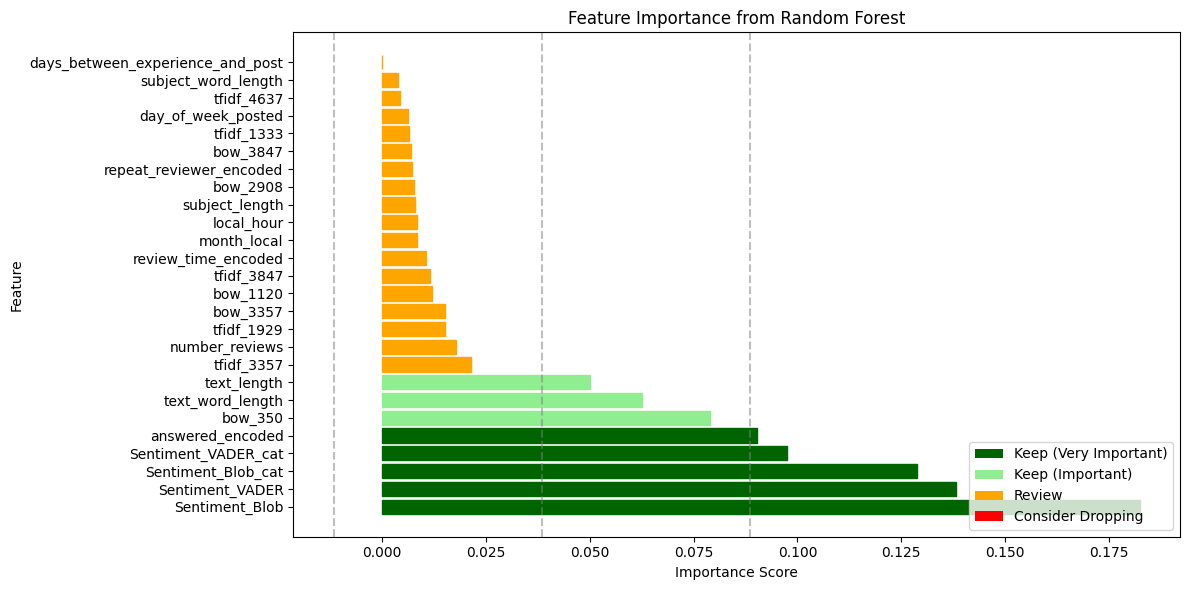

In [99]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

def analyze_random_forest_importance():
    # Collect features
    features_to_include = []
    
    # Add numeric features
    features_to_include.extend(true_numeric)
    features_to_include.extend(time_based_numeric)
    
    # Add encoded binary features
    features_to_include.extend([f for f in binary_variables if f.endswith('_encoded')])
    
    # Add ordinal features (excluding rating)
    features_to_include.extend([f for f in categorical_ordinal if f != 'rating'])
    
    # Create initial X matrix
    X = train_df[features_to_include].copy()
    
    # Add TF-IDF if available
    if 'tfidf_df' in globals() and len(top_tfidf_cols) > 0:
        X = pd.concat([X, tfidf_df[top_tfidf_cols]], axis=1)
    
    # Add BoW if available
    if 'bow_df' in globals() and len(top_bow_cols) > 0:
        X = pd.concat([X, bow_df[top_bow_cols]], axis=1)
    
    y = train_df['rating']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize and fit Random Forest with parameters to reduce overfitting
    rf = RandomForestClassifier(
        n_estimators=100,
        max_depth=10,  # Limit depth
        min_samples_split=5,  # Require more samples to split
        min_samples_leaf=2,  # Require more samples in leaves
        n_jobs=-1,
        random_state=42
    )
    
    rf.fit(X_scaled, y)
    
    # Get and organize feature importance
    importance_df = pd.DataFrame({
        'feature': X.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Calculate mean and std of feature importance
    mean_importance = importance_df['importance'].mean()
    std_importance = importance_df['importance'].std()
    
    # Classify features based on importance
    importance_df['status'] = importance_df['importance'].apply(
        lambda x: 'Keep (Very Important)' if x > mean_importance + std_importance
        else 'Keep (Important)' if x > mean_importance
        else 'Consider Dropping' if x < mean_importance - std_importance
        else 'Review'
    )
    
    print("Random Forest Feature Importance Analysis")
    print("=" * 50)
    
    # Print summary by importance category
    for status in ['Keep (Very Important)', 'Keep (Important)', 'Review', 'Consider Dropping']:
        features = importance_df[importance_df['status'] == status]
        if not features.empty:
            print(f"\n{status}:")
            for _, row in features.iterrows():
                print(f"  - {row['feature']}: {row['importance']:.4f}")
    
    print("\nImportance Thresholds:")
    print(f"Very Important: > {(mean_importance + std_importance):.4f}")
    print(f"Important: > {mean_importance:.4f}")
    print(f"Review: > {(mean_importance - std_importance):.4f}")
    print(f"Consider Dropping: ≤ {(mean_importance - std_importance):.4f}")
    
    # Create visualization
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 6))
    colors = ['darkgreen', 'lightgreen', 'orange', 'red']
    status_colors = {
        'Keep (Very Important)': colors[0],
        'Keep (Important)': colors[1],
        'Review': colors[2],
        'Consider Dropping': colors[3]
    }
    
    bars = plt.barh(importance_df['feature'], importance_df['importance'])
    
    # Color bars by status
    for bar, status in zip(bars, importance_df['status']):
        bar.set_color(status_colors[status])
    
    plt.axvline(x=mean_importance + std_importance, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=mean_importance, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=mean_importance - std_importance, color='gray', linestyle='--', alpha=0.5)
    
    plt.xlabel('Importance Score')
    plt.ylabel('Feature')
    plt.title('Feature Importance from Random Forest')
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color, label=status)
                      for status, color in status_colors.items()]
    plt.legend(handles=legend_elements, loc='lower right')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'importance_df': importance_df,
        'thresholds': {
            'very_important': mean_importance + std_importance,
            'important': mean_importance,
            'review': mean_importance - std_importance
        }
    }

# Run analysis
rf_results = analyze_random_forest_importance()

STAGE 13 - LOGISTIC REGRESSION WITH RIB RATIO STUDY

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def analyze_logistic_rib_ratio(column_name, data, feature_type='numeric'):
    """Analyze feature importance using logistic regression with RIB ratio study"""
    if column_name not in data.columns:
        return None
    
    # Prepare data
    y = (data['rating'] >= 4).astype(int)  # Binary: 1 for high rating (>=4), 0 for low rating
    X = data[column_name].values.reshape(-1, 1)
    
    try:
        # Calculate RIB ratios
        n_bins = 10 if feature_type != 'binary' else 2
        bins = np.percentile(X.ravel(), np.linspace(0, 100, n_bins))
        bin_indices = np.digitize(X.ravel(), bins)
        
        rib_ratios = []
        bin_sizes = []
        for i in range(1, len(bins) + 1):
            mask = bin_indices == i
            if sum(mask) > 0:
                ratio = np.mean(y[mask]) / (1 - np.mean(y[mask]) + 1e-10)
                rib_ratios.append(ratio)
                bin_sizes.append(sum(mask))
        
        # Calculate RIB ratio stability
        rib_stability = np.std(rib_ratios) / (np.mean(rib_ratios) + 1e-10)
        
        # Fit logistic regression
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model = LogisticRegression(random_state=42, max_iter=1000)
        model.fit(X_train, y_train)
        
        # Calculate metrics
        coef = model.coef_[0][0]
        odds_ratio = np.exp(coef)
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        auc_score = roc_auc_score(y_test, y_pred_proba)
        
        # Calculate point-biserial correlation
        correlation, p_value = stats.pointbiserialr(y, X.ravel())
        
        # Calculate importance metrics
        max_rib = max(rib_ratios)
        min_rib = min(rib_ratios)
        rib_range = max_rib - min_rib
        
        # Determine feature strength
        if feature_type == 'binary':
            strength_threshold = 0.3
        else:
            strength_threshold = 0.5
            
        strength = (
            "strong" if (abs(correlation) >= strength_threshold and rib_range > 1.5) else
            "moderate" if (abs(correlation) >= strength_threshold/2 and rib_range > 1.0) else
            "weak"
        )
        
        return {
            'feature': column_name,
            'type': feature_type,
            'coef': coef,
            'odds_ratio': odds_ratio,
            'correlation': correlation,
            'p_value': p_value,
            'auc': auc_score,
            'rib_max': max_rib,
            'rib_min': min_rib,
            'rib_range': rib_range,
            'rib_stability': rib_stability,
            'strength': strength,
            'significant': p_value < 0.05 and rib_range > 1.0,
            'keep': (p_value < 0.05 and 
                    rib_range > 1.0 and 
                    rib_stability < 1.0 and 
                    auc_score > 0.6)
        }
        
    except Exception as e:
        print(f"Error analyzing {column_name}: {str(e)}")
        return None

def run_rib_analysis():
    results = []
    
    # Analyze features by type
    feature_groups = {
        'numeric': true_numeric + time_based_numeric,
        'binary': [f for f in binary_variables if f.endswith('_encoded')],
        'ordinal': [f for f in categorical_ordinal if f != 'rating']
    }
    
    for feature_type, features in feature_groups.items():
        for feature in features:
            if feature in train_df.columns:
                result = analyze_logistic_rib_ratio(feature, train_df, feature_type)
                if result is not None:  # Only append if analysis was successful
                    results.append(result)
    
    if not results:  # Check if we have any results
        print("No features were successfully analyzed.")
        return None
    
    # Create DataFrame only if we have results
    results_df = pd.DataFrame(results)
    
    # Print results
    print("\nLogistic Regression with RIB Ratio Analysis")
    print("=" * 50)
    
    if 'type' in results_df.columns:  # Check if 'type' column exists
        for feature_type in results_df['type'].unique():
            type_results = results_df[results_df['type'] == feature_type]
            if not type_results.empty:
                print(f"\n{feature_type.title()} Features:")
                
                # Strong predictors
                strong = type_results[type_results['keep']]
                if not strong.empty:
                    print("\nRecommended features:")
                    for _, row in strong.iterrows():
                        print(f"  - {row['feature']}:")
                        print(f"    Odds ratio: {row['odds_ratio']:.3f}")
                        print(f"    RIB range: {row['rib_range']:.3f}")
                        print(f"    RIB stability: {row['rib_stability']:.3f}")
                        print(f"    AUC: {row['auc']:.3f}")
                
                # Weak predictors
                weak = type_results[~type_results['keep']]
                if not weak.empty:
                    print("\nNot recommended:")
                    for _, row in weak.iterrows():
                        print(f"  - {row['feature']} (RIB range: {row['rib_range']:.3f}, "
                              f"p={row['p_value']:.3e})")
    
    return results_df

# Run analysis
rib_results = run_rib_analysis()


Logistic Regression with RIB Ratio Analysis

Numeric Features:

Recommended features:
  - number_reviews:
    Odds ratio: 0.711
    RIB range: 1.813
    RIB stability: 0.531
    AUC: 0.641
  - text_length:
    Odds ratio: 0.994
    RIB range: 4.124
    RIB stability: 0.701
    AUC: 0.703
  - text_word_length:
    Odds ratio: 0.955
    RIB range: 4.430
    RIB stability: 0.726
    AUC: 0.714

Not recommended:
  - Sentiment_Blob (RIB range: 32.819, p=0.000e+00)
  - Sentiment_VADER (RIB range: 9999999999.945, p=0.000e+00)
  - subject_length (RIB range: 1.241, p=6.136e-82)
  - subject_word_length (RIB range: 1.099, p=4.647e-161)
  - days_between_experience_and_post (RIB range: 0.000, p=nan)
  - month_local (RIB range: 0.322, p=3.211e-07)
  - local_hour (RIB range: 1.034, p=5.638e-80)
  - day_of_week_posted (RIB range: 0.946, p=7.043e-137)

Binary Features:

Recommended features:
  - repeat_reviewer_encoded:
    Odds ratio: 0.411
    RIB range: 1.268
    RIB stability: 0.422
    AUC: 0.614

STAGE 14 - ENCODING

In [101]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import pandas as pd
import numpy as np

def encode_features(train_df, test_df):
    """Encode categorical features while preserving original columns"""
    
    # 1. Ordinal Encoding
    # time_of_day encoding
    time_of_day_order = ['Morning', 'Business Hours', 'Evening', 'Night']
    train_df['time_of_day_encoded'] = pd.Categorical(
        train_df['time_of_day'], 
        categories=time_of_day_order
    ).codes
    test_df['time_of_day_encoded'] = pd.Categorical(
        test_df['time_of_day'], 
        categories=time_of_day_order
    ).codes
    
    # verification encoding
    verification_order = ['Verified', 'Invited', 'Redirected', 'Not Verified']
    train_df['verification_encoded'] = pd.Categorical(
        train_df['verification'], 
        categories=verification_order
    ).codes
    test_df['verification_encoded'] = pd.Categorical(
        test_df['verification'], 
        categories=verification_order
    ).codes
    
    # 2. Label Encoding for location
    # Get all unique locations from both train and test
    all_locations = pd.concat([train_df['location'], test_df['location']]).unique()
    location_map = {loc: idx for idx, loc in enumerate(sorted(all_locations))}
    
    train_df['location_encoded'] = train_df['location'].map(location_map)
    test_df['location_encoded'] = test_df['location'].map(location_map)
    
    # 3. One-Hot Encoding
    # Get all unique values from both train and test for each categorical column
    for column in ['company', 'day_type']:
        # Get all possible values from both datasets
        all_values = pd.concat([train_df[column], test_df[column]]).unique()
        
        # Create dummy columns for train
        dummy_cols = pd.get_dummies(train_df[column], prefix=column, dtype=int)
        train_df = pd.concat([train_df, dummy_cols], axis=1)
        
        # Create dummy columns for test
        dummy_cols_test = pd.get_dummies(test_df[column], prefix=column, dtype=int)
        
        # Ensure both datasets have the same columns
        for val in all_values:
            col_name = f"{column}_{val}"
            if col_name not in dummy_cols.columns:
                train_df[col_name] = 0
            if col_name not in dummy_cols_test.columns:
                test_df[col_name] = 0
    
    return train_df, test_df

# Apply encoding to train and test sets
train_df, test_df = encode_features(train_df, test_df)

In [102]:
display(train_df.head())
print(train_df.info())

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded,time_of_day_encoded,verification_encoded,location_encoded,company_Asda,company_Flashbay,company_Quicken,company_SteelSeries,day_type_Business Day,day_type_Weekend
0,5,US,Paul D.,1,Verified,one-time,0,Flashbay,fast and efficient web site that allowed a simple interface to to upload my logo and choose my product. The whole process was quick and the product was of great quality.,fast efficient web site allowed simple interface upload logo choose product whole process quick product great quality,117,17,0.307,4.0,0.784,5,fast and efficient web site that…,fast efficient web site,23.0,4.0,"Hello Paul,That is Flashbay for you!Glad that you have found the ordering process easy, and are pleased with the final product.We appreciate your business, and look forward to working with you next time!-Flashbay Management",hello paulthat flashbay youglad found ordering process easy pleased final productwe appreciate business look forward working next timeflashbay management,1,2021-08-11,2021-08-11 17:03:19,2021-08-11,8,10,Business Hours,2,Business Day,0,quick_review,1,1,0,135,0,1,0,0,1,0
1,4,US,Tim Deutschle,1,Verified,one-time,0,Quicken,"I have used Quicken for many years, more than 30 years for sure. I find it difficult sometimes when adding accounts. Also, when entering CD’s and establishing a maturity schedule.",used quicken many years 30 years sure find difficult sometimes adding accounts also entering cds establishing maturity schedule,127,18,0.167,3.0,-0.052,3,I have used Quicken for many years,used quicken many years,23.0,4.0,0,0,0,2024-04-24,2024-05-01 16:23:54,2024-05-01,5,9,Business Hours,2,Business Day,0,late_review,0,1,0,135,0,0,1,0,1,0
2,1,GB,Matthew Hanshaw,2,Not Verified,repeat,1,Asda,A pile of s**t !!!!!!!!!!! Also you don’t even warrant a star had to select it to leave this review.,pile st also dont even warrant star select leave review,55,10,0.000,3.0,-0.052,3,A pile of s**t,pile st,7.0,2.0,0,0,0,2023-08-07,2023-08-08 21:16:55,2023-08-08,8,20,Evening,1,Business Day,0,late_review,0,2,3,52,1,0,0,0,1,0
3,2,US,Michael,1,Invited,one-time,0,Quicken,Not a super useful or intuitive tool. Better free options exist.,super useful intuitive tool better free options exist,53,8,0.383,4.0,0.919,5,Not a super useful or intuitive tool,super useful intuitive tool,27.0,4.0,0,0,0,2023-09-05,2023-09-05 18:27:02,2023-09-05,9,11,Business Hours,1,Business Day,0,quick_review,1,1,1,135,0,0,1,0,1,0
4,2,US,Alan,2,Invited,repeat,1,Quicken,not intuitive....poor guidelines and instructions on usage,intuitivepoor guidelines instructions usage,43,4,0.000,3.0,0.000,3,not intuitive....poor guidelines and…,intuitivepoor guidelines,24.0,2.0,0,0,0,2021-12-08,2021-12-08 02:43:54,2021-12-07,12,19,Evening,1,Business Day,0,quick_review,1,2,1,135,0,0,1,0,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51382 entries, 0 to 51381
Data columns (total 43 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   rating                            51382 non-null  int64         
 1   location                          51382 non-null  object        
 2   username                          51382 non-null  object        
 3   number_reviews                    51382 non-null  int64         
 4   verification                      51382 non-null  object        
 5   repeat_reviewer                   51382 non-null  object        
 6   repeat_reviewer_encoded           51382 non-null  int64         
 7   company                           51382 non-null  object        
 8   text                              51382 non-null  object        
 9   text_processed                    51382 non-null  object        
 10  text_length                       51382 non-nu

STAGE 15 - SCALING/NORMALIZATION/STANDARDIZATION

In [103]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

def scale_features(train_df, test_df):
   """Scale features appropriately while preserving original columns"""
   
   # Features requiring standardization
   standardize_columns = [
       'text_length', 'subject_length',
       'text_word_length', 'subject_word_length',
       'days_between_experience_and_post',
       'number_reviews'
   ]
   
   # Features requiring normalization  
   normalize_columns = [
       'location_encoded',
       'verification_encoded',
       'time_of_day_encoded'
   ]
   
   # Initialize scalers
   std_scaler = StandardScaler()
   minmax_scaler = MinMaxScaler()
   
   # Apply StandardScaler
   if standardize_columns:
       train_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.fit_transform(
           train_df[standardize_columns]
       )
       test_df[[col + '_scaled' for col in standardize_columns]] = std_scaler.transform(
           test_df[standardize_columns]
       )
   
   # Apply MinMaxScaler
   if normalize_columns:
       train_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.fit_transform(
           train_df[normalize_columns]
       )
       test_df[[col + '_normalized' for col in normalize_columns]] = minmax_scaler.transform(
           test_df[normalize_columns]
       )
   
   return train_df, test_df, {'standard': std_scaler, 'minmax': minmax_scaler}

# Apply scaling
train_df, test_df, scalers = scale_features(train_df, test_df)

# Verify results
print("\nTraining set statistics after scaling:")
print("\nStandardized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_scaled')]].describe())
print("\nNormalized features:")
print(train_df[[col for col in train_df.columns if col.endswith('_normalized')]].describe())


Training set statistics after scaling:

Standardized features:
       text_length_scaled  subject_length_scaled  text_word_length_scaled  subject_word_length_scaled  days_between_experience_and_post_scaled  number_reviews_scaled
count           5.138e+04              5.138e+04                5.138e+04                   5.138e+04                                  51382.0              5.138e+04
mean            1.673e-17              8.781e-18                4.010e-17                  -3.927e-17                                      0.0              6.085e-18
std             1.000e+00              1.000e+00                1.000e+00                   1.000e+00                                      0.0              1.000e+00
min            -1.255e+00             -2.373e+00               -1.206e+00                  -1.702e+00                                      0.0             -6.759e-01
25%            -7.726e-01             -6.990e-01               -7.871e-01                  -3.561e-01     

In [104]:
display(train_df.head())

,rating,location,username,number_reviews,verification,repeat_reviewer,repeat_reviewer_encoded,company,text,text_processed,text_length,text_word_length,Sentiment_Blob,Sentiment_Blob_cat,Sentiment_VADER,Sentiment_VADER_cat,subject,subject_processed,subject_length,subject_word_length,answer,answer_processed,answered_encoded,date_of_experience,date_posted,local_date_posted,month_local,local_hour,time_of_day,day_of_week_posted,day_type,days_between_experience_and_post,review_time,review_time_encoded,time_of_day_encoded,verification_encoded,location_encoded,company_Asda,company_Flashbay,company_Quicken,company_SteelSeries,day_type_Business Day,day_type_Weekend,text_length_scaled,subject_length_scaled,text_word_length_scaled,subject_word_length_scaled,days_between_experience_and_post_scaled,number_reviews_scaled,location_encoded_normalized,verification_encoded_normalized,time_of_day_encoded_normalized
0,5,US,Paul D.,1,Verified,one-time,0,Flashbay,fast and efficient web site that allowed a simple interface to to upload my logo and choose my product. The whole process was quick and the product was of great quality.,fast efficient web site allowed simple interface upload logo choose product whole process quick product great quality,117,17,0.307,4.0,0.784,5,fast and efficient web site that…,fast efficient web site,23.0,4.0,"Hello Paul,That is Flashbay for you!Glad that you have found the ordering process easy, and are pleased with the final product.We appreciate your business, and look forward to working with you next time!-Flashbay Management",hello paulthat flashbay youglad found ordering process easy pleased final productwe appreciate business look forward working next timeflashbay management,1,2021-08-11,2021-08-11 17:03:19,2021-08-11,8,10,Business Hours,2,Business Day,0,quick_review,1,1,0,135,0,1,0,0,1,0,-0.382,-0.029,-0.368,0.541,0.0,-0.676,0.944,0.000,0.333
1,4,US,Tim Deutschle,1,Verified,one-time,0,Quicken,"I have used Quicken for many years, more than 30 years for sure. I find it difficult sometimes when adding accounts. Also, when entering CD’s and establishing a maturity schedule.",used quicken many years 30 years sure find difficult sometimes adding accounts also entering cds establishing maturity schedule,127,18,0.167,3.0,-0.052,3,I have used Quicken for many years,used quicken many years,23.0,4.0,0,0,0,2024-04-24,2024-05-01 16:23:54,2024-05-01,5,9,Business Hours,2,Business Day,0,late_review,0,1,0,135,0,0,1,0,1,0,-0.305,-0.029,-0.315,0.541,0.0,-0.676,0.944,0.000,0.333
2,1,GB,Matthew Hanshaw,2,Not Verified,repeat,1,Asda,A pile of s**t !!!!!!!!!!! Also you don’t even warrant a star had to select it to leave this review.,pile st also dont even warrant star select leave review,55,10,0.000,3.0,-0.052,3,A pile of s**t,pile st,7.0,2.0,0,0,0,2023-08-07,2023-08-08 21:16:55,2023-08-08,8,20,Evening,1,Business Day,0,late_review,0,2,3,52,1,0,0,0,1,0,-0.857,-1.815,-0.735,-1.253,0.0,-0.093,0.364,1.000,0.667
3,2,US,Michael,1,Invited,one-time,0,Quicken,Not a super useful or intuitive tool. Better free options exist.,super useful intuitive tool better free options exist,53,8,0.383,4.0,0.919,5,Not a super useful or intuitive tool,super useful intuitive tool,27.0,4.0,0,0,0,2023-09-05,2023-09-05 18:27:02,2023-09-05,9,11,Business Hours,1,Business Day,0,quick_review,1,1,1,135,0,0,1,0,1,0,-0.872,0.417,-0.839,0.541,0.0,-0.676,0.944,0.333,0.333
4,2,US,Alan,2,Invited,repeat,1,Quicken,not intuitive....poor guidelines and instructions on usage,intuitivepoor guidelines instructions usage,43,4,0.000,3.0,0.000,3,not intuitive....poor guidelines and…,intuitivepoor guidelines,24.0,2.0,0,0,0,2021-12-08,2021-12-08 02:43:54,2021-12-07,12,19,Evening,1,Business Day,0,quick_review,1,2,1,135,0,0,1,0,1,0,-0.949,0.082,-1.049,-1.253,0.0,-0.093,0.944,0.333,0.667


STAGE 16 - DIMENSIONALITY REDUCTION

STAGE 14 - VALIDATE AND COMPARE METHODS

Normalizing scores...
Generating recommendations...

Analysis Summary:



Detailed Results:


,feature,pearson,spearman,mutual_info,random_forest,lasso,mean_score,score_std,recommendation
0,number_reviews,0.543667,0.450161,0.223899,0.145630,0.005984,0.273868,0.220553,Consider Keeping
1,repeat_reviewer_encoded,0.402136,0.369122,0.108684,0.058370,0.059579,0.199578,0.171447,Consider Keeping
2,text_length,0.669553,0.571081,0.294640,0.476491,0.000001,0.402353,0.264032,Keep
3,text_word_length,0.708409,0.606360,0.337344,0.389870,1.000000,0.608397,0.266732,Keep
4,Sentiment_Blob,0.971720,1.000000,1.000000,1.000000,0.356090,0.865562,0.285067,Keep
5,Sentiment_Blob_cat,0.926332,0.938450,0.759908,0.425724,0.156371,0.641357,0.341042,Consider Keeping
6,Sentiment_VADER,1.000000,0.924420,0.910474,0.815953,0.626674,0.855504,0.143682,Strong Keep
7,Sentiment_VADER_cat,0.986937,0.926783,0.736981,0.363205,0.000000,0.602781,0.415724,Review (Conflicting Results)
8,subject_length,0.137508,0.103065,0.048198,0.388994,0.049317,0.145416,0.141309,Consider Keeping
9,subject_word_length,0.205106,0.162827,0.044514,0.170314,0.000498,0.116652,0.088785,Consider Keeping



Feature Importance Heatmap:


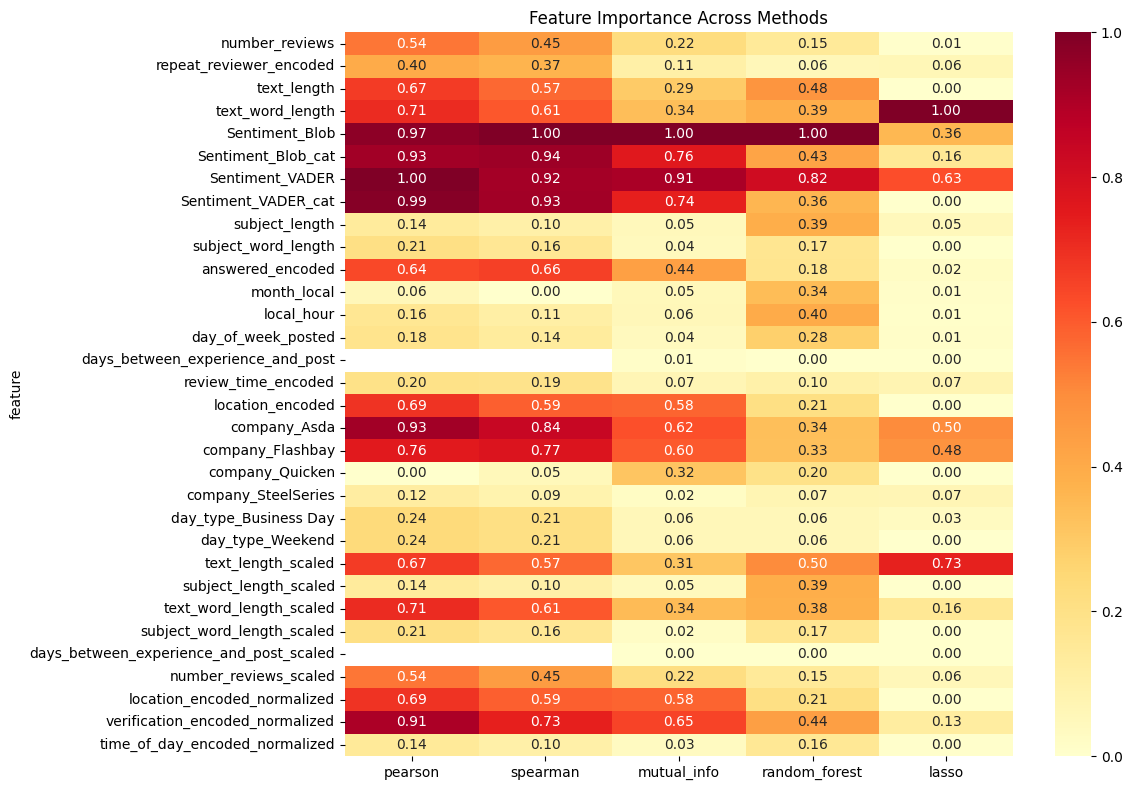

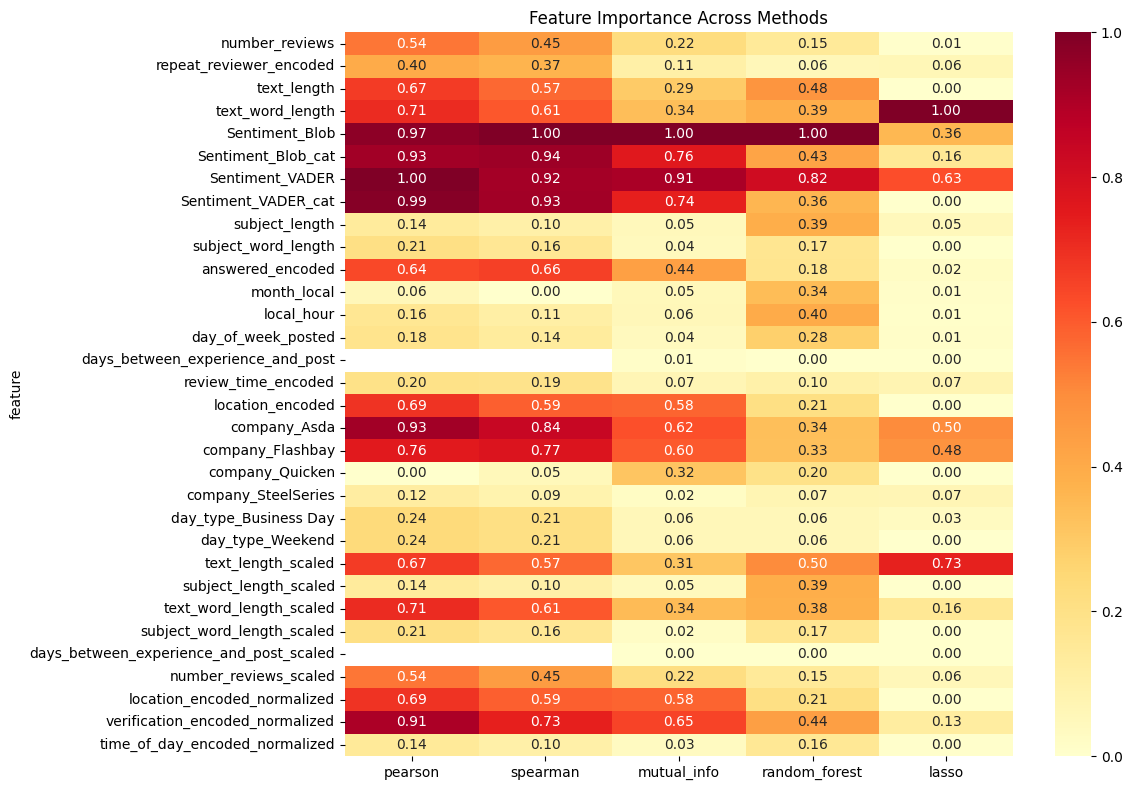

In [105]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML, display

def collect_all_scores(df, target_col='rating'):
    # Get feature columns (numeric only)
    features = df.select_dtypes(include=['int64', 'float64']).columns
    features = [col for col in features if col != target_col]
    
    # Initialize results dictionary
    scores = {
        'feature': features,
        'pearson': [],
        'spearman': [],
        'mutual_info': [],
        'random_forest': [],
        'lasso': []
    }
    
    # Prepare data
    X = df[features]
    y = df[target_col]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Calculate scores for each feature
    for feature in features:
        # Correlation scores
        pearson_coef, _ = pearsonr(df[feature], y)
        spearman_coef, _ = spearmanr(df[feature], y)
        
        scores['pearson'].append(abs(pearson_coef))
        scores['spearman'].append(abs(spearman_coef))
    
    # Mutual Information
    scores['mutual_info'] = mutual_info_regression(X, y)
    
    # Random Forest importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_scaled, y)
    scores['random_forest'] = rf.feature_importances_
    
    # Lasso importance
    lasso = LassoCV(cv=5, random_state=42)
    lasso.fit(X_scaled, y)
    scores['lasso'] = np.abs(lasso.coef_)
    
    # Convert to DataFrame
    scores_df = pd.DataFrame(scores)
    return scores_df

def normalize_scores(scores_df):
    # Get feature column
    features = scores_df['feature']
    
    # Normalize each method's scores
    methods = ['pearson', 'spearman', 'mutual_info', 'random_forest', 'lasso']
    normalized_scores = scores_df[methods].apply(lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else x)
    
    # Add features back
    normalized_scores.insert(0, 'feature', features)
    
    return normalized_scores

def get_feature_recommendations(scores_df):
    # Calculate mean and std of scores for each feature
    score_cols = ['pearson', 'spearman', 'mutual_info', 'random_forest', 'lasso']
    scores_df['mean_score'] = scores_df[score_cols].mean(axis=1)
    scores_df['score_std'] = scores_df[score_cols].std(axis=1)
    
    # Generate recommendations
    def get_recommendation(row):
        if row['mean_score'] >= 0.7 and row['score_std'] < 0.2:
            return "Strong Keep"
        elif row['mean_score'] >= 0.4 and row['score_std'] < 0.3:
            return "Keep"
        elif row['mean_score'] >= 0.1 and row['score_std'] < 0.4:
            return "Consider Keeping"
        elif row['score_std'] >= 0.4:
            return "Review (Conflicting Results)"
        else:
            return "Consider Removing"
    
    scores_df['recommendation'] = scores_df.apply(get_recommendation, axis=1)
    return scores_df

def create_summary(final_scores):
    summary = []
    summary.append("Feature Selection Analysis Summary")
    summary.append("=" * 50)
    
    # Overall recommendations
    summary.append("\nRecommendations:")
    for recommendation in final_scores['recommendation'].unique():
        features = final_scores[final_scores['recommendation'] == recommendation]
        summary.append(f"\n{recommendation}:")
        for _, row in features.iterrows():
            summary.append(f"- {row['feature']} (mean score: {row['mean_score']:.3f})")
    
    return "\n".join(summary)

def plot_importance_heatmap(scores_df):
    plt.figure(figsize=(12, 8))
    score_cols = ['pearson', 'spearman', 'mutual_info', 'random_forest', 'lasso']
    heatmap_data = scores_df.set_index('feature')[score_cols]
    sns.heatmap(heatmap_data, annot=True, cmap='YlOrRd', fmt='.2f')
    plt.title('Feature Importance Across Methods')
    plt.tight_layout()
    return plt.gcf()

def analyze_features(df, target_col='rating'):
    # 1. Collect all scores
    print("Collecting scores from all methods...")
    scores = collect_all_scores(df, target_col)
    
    # 2. Normalize scores
    print("Normalizing scores...")
    normalized_scores = normalize_scores(scores)
    
    # 3. Generate recommendations
    print("Generating recommendations...")
    final_scores = get_feature_recommendations(normalized_scores)
    
    # 4. Create summary
    print("\nAnalysis Summary:")
    summary = create_summary(final_scores)
    display(HTML(f"<pre>{summary}</pre>"))
    
    # 5. Show detailed results
    print("\nDetailed Results:")
    display(final_scores.style
           .background_gradient(subset=['mean_score'])
           .set_caption("Feature Selection Results"))
    
    # 6. Show visualization
    print("\nFeature Importance Heatmap:")
    display(plot_importance_heatmap(normalized_scores))
    
    return final_scores

results = analyze_features(train_df)

In [106]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

def analyze_final_features(df, target_col='rating', vif_threshold=5, corr_threshold=0.7):
    # Initial feature sets before multicollinearity check
    initial_features = {
        'conservative': [
            'verification', 
            'answered', 
            'repeat_reviewer_encoded',
            'day_of_week_posted',
            'day_type',
            'review_time',
            'month_posted',
            'local_hour'
        ],
        'strict': [
            'verification',
            'answered',
            'repeat_reviewer_encoded'
        ]
    }
    
    results = {}
    
    # 1. Check multicollinearity and get cleaned feature sets
    print("Analyzing multicollinearity...")
    multi_results = check_multicollinearity(df, initial_features['conservative'], 
                                          target_col, vif_threshold, corr_threshold)
    results['multicollinearity'] = multi_results
    
    # Update feature sets based on multicollinearity analysis
    cleaned_features = multi_results['cleaned_features']
    
    # Update conservative and strict approaches
    conservative_features = cleaned_features
    strict_features = [f for f in cleaned_features if f in initial_features['strict']]
    
    print("\nAfter multicollinearity handling:")
    print(f"Conservative features: {conservative_features}")
    print(f"Strict features: {strict_features}")
    
    # 2. Validate both feature sets
    print("\nValidating feature sets...")
    conservative_metrics = validate_feature_set(df, conservative_features, target_col)
    strict_metrics = validate_feature_set(df, strict_features, target_col)
    
    results['conservative'] = {
        'features': conservative_features,
        'metrics': conservative_metrics
    }
    results['strict'] = {
        'features': strict_features,
        'metrics': strict_metrics
    }
    
    # 3. Generate final importance ranking for both approaches
    print("\nGenerating final importance ranking...")
    importance_ranking = get_final_importance_ranking(df, conservative_features, strict_features, target_col)
    results['importance_ranking'] = importance_ranking
    
    # Display results
    display_comprehensive_results(results)
    
    return results

def check_multicollinearity(df, features, target_col, vif_threshold=5, corr_threshold=0.7):
    features_to_check = [f for f in features if f in df.columns]
    X = df[features_to_check]
    
    # Calculate initial VIF
    scaler = StandardScaler()
    X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
    
    vif_data = pd.DataFrame()
    vif_data["Feature"] = X_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) 
                       for i in range(X_scaled.shape[1])]
    
    # Calculate correlation matrix
    corr_matrix = X.corr()
    
    # Calculate correlation with target for importance assessment
    target_correlations = X.apply(lambda x: abs(x.corr(df[target_col])))
    
    # Find features to remove due to multicollinearity
    features_to_remove = set()
    
    # Check VIF
    high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
    if high_vif_features:
        # Remove features with highest VIF iteratively
        while len(high_vif_features) > 0:
            # Remove feature with highest VIF and lowest correlation with target
            worst_feature = min(high_vif_features, 
                              key=lambda x: target_correlations[x])
            features_to_remove.add(worst_feature)
            
            # Recalculate VIF without the removed feature
            remaining_features = [f for f in X.columns if f not in features_to_remove]
            if not remaining_features:
                break
                
            X_subset = X[remaining_features]
            X_scaled = pd.DataFrame(scaler.fit_transform(X_subset), 
                                  columns=X_subset.columns)
            
            vif_data = pd.DataFrame()
            vif_data["Feature"] = X_scaled.columns
            vif_data["VIF"] = [variance_inflation_factor(X_scaled.values, i) 
                              for i in range(X_scaled.shape[1])]
            
            high_vif_features = vif_data[vif_data["VIF"] > vif_threshold]["Feature"].tolist()
    
    # Check correlations
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > corr_threshold:
                feat1 = corr_matrix.columns[i]
                feat2 = corr_matrix.columns[j]
                corr = corr_matrix.iloc[i, j]
                
                # Decide which feature to remove based on correlation with target
                if target_correlations[feat1] < target_correlations[feat2]:
                    features_to_remove.add(feat1)
                else:
                    features_to_remove.add(feat2)
                    
                high_corr_pairs.append({
                    'feature1': feat1,
                    'feature2': feat2,
                    'correlation': corr,
                    'removed': feat1 if target_correlations[feat1] < target_correlations[feat2] else feat2
                })
    
    # Get final cleaned feature set
    cleaned_features = [f for f in features if f not in features_to_remove]
    
    return {
        'vif': vif_data,
        'correlation_matrix': corr_matrix,
        'high_correlations': high_corr_pairs,
        'removed_features': list(features_to_remove),
        'cleaned_features': cleaned_features
    }

def validate_feature_set(df, features, target_col):
    X = df[features]
    y = df[target_col]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    scoring = {
        'accuracy': make_scorer(accuracy_score),
        'precision': make_scorer(precision_score, average='weighted'),
        'recall': make_scorer(recall_score, average='weighted'),
        'f1': make_scorer(f1_score, average='weighted')
    }
    
    metrics = {}
    for metric_name, scorer in scoring.items():
        cv_scores = cross_val_score(rf, X_scaled, y, scoring=scorer, cv=5)
        metrics[metric_name] = {
            'mean': cv_scores.mean(),
            'std': cv_scores.std()
        }
    
    return metrics

def get_final_importance_ranking(df, conservative_features, strict_features, target_col):
    X_conservative = df[conservative_features]
    X_strict = df[strict_features]
    y = df[target_col]
    
    scaler = StandardScaler()
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    
    # Get conservative approach importance
    X_cons_scaled = scaler.fit_transform(X_conservative)
    rf.fit(X_cons_scaled, y)
    conservative_importance = pd.DataFrame({
        'feature': conservative_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Get strict approach importance
    X_strict_scaled = scaler.fit_transform(X_strict)
    rf.fit(X_strict_scaled, y)
    strict_importance = pd.DataFrame({
        'feature': strict_features,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'conservative': conservative_importance,
        'strict': strict_importance
    }

def display_comprehensive_results(results):

    print("\nMulticollinearity Analysis Results:")
    print("=" * 50)
    
    # Display removed features
    print("\nFeatures removed due to multicollinearity:")
    if results['multicollinearity']['removed_features']:
        for feature in results['multicollinearity']['removed_features']:
            print(f"- {feature}")
    else:
        print("No features removed")
    
    # Display high correlations
    print("\nHighly Correlated Feature Pairs:")
    if results['multicollinearity']['high_correlations']:
        for pair in results['multicollinearity']['high_correlations']:
            print(f"{pair['feature1']} & {pair['feature2']}: {pair['correlation']:.3f}")
            print(f"Removed: {pair['removed']}")
    else:
        print("No highly correlated pairs found")
    
    # Plot correlation heatmap for final features
    plt.figure(figsize=(10, 8))
    sns.heatmap(results['multicollinearity']['correlation_matrix'], 
                annot=True, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.show()
    
    # Display validation results
    print("\nFeature Set Validation Results:")
    print("=" * 50)
    
    print("\nConservative Approach:")
    print("-" * 30)
    print("Features:", ", ".join(results['conservative']['features']))
    for metric, scores in results['conservative']['metrics'].items():
        print(f"{metric}: {scores['mean']:.3f} (±{scores['std']:.3f})")
    
    print("\nStrict Approach:")
    print("-" * 30)
    print("Features:", ", ".join(results['strict']['features']))
    for metric, scores in results['strict']['metrics'].items():
        print(f"{metric}: {scores['mean']:.3f} (±{scores['std']:.3f})")
    
    # Display feature importance rankings
    print("\nFeature Importance Rankings:")
    print("=" * 50)
    
    print("\nConservative Approach Importance:")
    print("-" * 30)
    display(results['importance_ranking']['conservative'])
    
    print("\nStrict Approach Importance:")
    print("-" * 30)
    display(results['importance_ranking']['strict'])
    
    # Compare relative importance changes
    common_features = set(results['importance_ranking']['strict']['feature']) & \
                     set(results['importance_ranking']['conservative']['feature'])
    
    if common_features:
        print("\nFeature Importance Comparison (Strict vs Conservative):")
        print("-" * 30)
        for feature in common_features:
            strict_imp = results['importance_ranking']['strict'][
                results['importance_ranking']['strict']['feature'] == feature]['importance'].iloc[0]
            cons_imp = results['importance_ranking']['conservative'][
                results['importance_ranking']['conservative']['feature'] == feature]['importance'].iloc[0]
            print(f"{feature}:")
            print(f"  Strict: {strict_imp:.3f}")
            print(f"  Conservative: {cons_imp:.3f}")
            print(f"  Change: {(strict_imp - cons_imp):.3f}")


results = analyze_final_features(train_df)


Analyzing multicollinearity...


ValueError: could not convert string to float: 'Verified'

In [23]:
train_df.describe()

,rating,verification,repeat_reviewer_encoded,answered,local_date_posted,month_posted,local_hour,time_of_day,day_of_week_posted,day_type,review_time
count,62723.000,62723.000,62723.000,62723.000,62723,62723.00,62723.000,62723.000,62723.00,62723.000,62723.000
mean,3.521,0.646,0.438,0.248,2021-01-23 02:10:55.797713664,6.16,12.386,2.270,2.61,0.816,0.802
min,1.000,0.000,0.000,0.000,2009-06-09 00:00:00,1.00,0.000,0.000,0.00,0.000,0.000
25%,1.000,0.000,0.000,0.000,2019-08-14 00:00:00,3.00,9.000,2.000,1.00,1.000,1.000
50%,4.000,1.000,0.000,0.000,2021-11-14 00:00:00,5.00,12.000,3.000,2.00,1.000,1.000
75%,5.000,1.000,1.000,0.000,2023-05-14 00:00:00,9.00,16.000,3.000,4.00,1.000,1.000
max,5.000,1.000,1.000,1.000,2024-10-23 00:00:00,12.00,23.000,3.000,6.00,1.000,1.000
std,1.698,0.478,0.496,0.432,NaN,3.65,4.899,0.966,1.85,0.388,0.399


STAGE 17 - OVERSAMPLING/UNDERSAMPLING

In [25]:
print("Class distribution in training set:")
print(train_scaled['rating'].value_counts(normalize=True))

Class distribution in training set:
rating
5    0.497
1    0.252
4    0.095
3    0.092
2    0.064
Name: proportion, dtype: float64


In [26]:
import numpy as np
import pandas as pd
from sklearn.utils import resample

def apply_balancing_methods(X_train, y_train, random_state=42):
    """
    Apply different balancing methods without external packages
    """
    results = {}
    
    # Store original data
    results['original'] = (X_train.copy(), y_train.copy())
    
    # 1. Random Oversampling
    # Identify minority classes and oversample each
    X_over = pd.DataFrame()
    y_over = pd.Series()
    target_size = y_train.value_counts().max()
    
    for class_value in y_train.unique():
        # Get indices for this class
        class_indices = y_train == class_value
        X_class = X_train[class_indices]
        y_class = y_train[class_indices]
        
        # If this is a minority class, oversample it
        if len(y_class) < target_size:
            X_resampled = resample(X_class, 
                                 n_samples=target_size,
                                 random_state=random_state)
            y_resampled = pd.Series([class_value] * target_size)
        else:
            X_resampled = X_class
            y_resampled = y_class
            
        X_over = pd.concat([X_over, X_resampled])
        y_over = pd.concat([y_over, y_resampled])
    
    results['oversampling'] = (X_over, y_over)
    
    # 2. Random Undersampling
    # Undersample majority classes to match minority class size
    X_under = pd.DataFrame()
    y_under = pd.Series()
    target_size = y_train.value_counts().min()
    
    for class_value in y_train.unique():
        # Get indices for this class
        class_indices = y_train == class_value
        X_class = X_train[class_indices]
        y_class = y_train[class_indices]
        
        # If this is a majority class, undersample it
        if len(y_class) > target_size:
            X_resampled = resample(X_class,
                                 n_samples=target_size,
                                 random_state=random_state)
            y_resampled = pd.Series([class_value] * target_size)
        else:
            X_resampled = X_class
            y_resampled = y_class
            
        X_under = pd.concat([X_under, X_resampled])
        y_under = pd.concat([y_under, y_resampled])
    
    results['undersampling'] = (X_under, y_under)
    
    # 3. Class Weights
    # Calculate class weights inversely proportional to class frequencies
    class_weights = dict(zip(
        np.unique(y_train),
        1/(np.bincount(y_train)[np.unique(y_train)])
    ))
    results['class_weights'] = class_weights
    
    return results

def print_distributions(results):
    """Print class distributions for each method"""
    print("Original class distribution:")
    print(results['original'][1].value_counts(normalize=True))
    
    print("\nOversampled class distribution:")
    print(results['oversampling'][1].value_counts(normalize=True))
    
    print("\nUndersampled class distribution:")
    print(results['undersampling'][1].value_counts(normalize=True))
    
    print("\nClass weights for weighted approach:")
    print(results['class_weights'])

# Apply the balancing methods
X = train_scaled.drop('rating', axis=1)
y = train_scaled['rating']

# Get balanced datasets
results = apply_balancing_methods(X, y)

# Print distributions
print_distributions(results)

# Store results for later use
balanced_datasets = {
    'original': results['original'],
    'oversampling': results['oversampling'],
    'undersampling': results['undersampling'],
    'class_weights': results['class_weights']
}

Original class distribution:
rating
5    0.497
1    0.252
4    0.095
3    0.092
2    0.064
Name: proportion, dtype: float64

Oversampled class distribution:
5    0.2
3    0.2
1    0.2
4    0.2
2    0.2
Name: proportion, dtype: float64

Undersampled class distribution:
5    0.2
3    0.2
1    0.2
4    0.2
2    0.2
Name: proportion, dtype: float64

Class weights for weighted approach:
{1: 6.328312871788382e-05, 2: 0.0002486325211337643, 3: 0.00017340038148083925, 4: 0.00016728002676480428, 5: 3.209860692045965e-05}


STAGE 18 - CROSS-VALIDATION

In [27]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

def evaluate_feature_set(X, y, balanced_datasets, feature_set_name, random_state=42):
    """
    Evaluate one feature set (Conservative or Strict) with different preprocessing methods
    """
    results = []
    
    # Try each sampling method
    for sampling_method in ['original', 'oversampling', 'undersampling']:
        # Get the appropriate dataset
        X_sampled = balanced_datasets[sampling_method][0][X.columns]
        y_sampled = balanced_datasets[sampling_method][1]
        
        # Basic Random Forest without class weights
        rf = RandomForestClassifier(n_estimators=100, random_state=random_state)
        scores = cross_val_score(rf, X_sampled, y_sampled, cv=5, scoring='accuracy')
        
        results.append({
            'Preprocessing Method': sampling_method,
            'Weight Method': 'None',
            'Mean CV Score': scores.mean(),
            'Std CV Score': scores.std()
        })
    
    # Try with class weights
    rf_weighted = RandomForestClassifier(
        n_estimators=100,
        class_weight=balanced_datasets['class_weights'],
        random_state=random_state
    )
    scores = cross_val_score(rf_weighted, X, y, cv=5, scoring='accuracy')
    
    results.append({
        'Preprocessing Method': 'original',
        'Weight Method': 'class_weights',
        'Mean CV Score': scores.mean(),
        'Std CV Score': scores.std()
    })
    
    results_df = pd.DataFrame(results).sort_values('Mean CV Score', ascending=False)
    
    print(f"\n{feature_set_name} Feature Set Results:")
    print("=" * 50)
    print(results_df)
    
    best_method = results_df.iloc[0]
    print(f"\nBest preprocessing for {feature_set_name}:")
    print(f"Method: {best_method['Preprocessing Method']}")
    print(f"Weights: {best_method['Weight Method']}")
    print(f"Score: {best_method['Mean CV Score']:.3f} (±{best_method['Std CV Score']:.3f})")
    
    return results_df

# Prepare conservative and strict feature sets
conservative_features = ['verification', 'answered', 'repeat_reviewer_encoded', 
                        'day_of_week_posted', 'day_type', 'review_time', 
                        'month_posted', 'local_hour']

strict_features = ['verification', 'answered', 'repeat_reviewer_encoded']

# Evaluate each feature set separately
X_conservative = train_scaled[conservative_features]
X_strict = train_scaled[strict_features]
y = train_scaled['rating']

# Get results for both approaches
conservative_results = evaluate_feature_set(X_conservative, y, balanced_datasets, "Conservative")
strict_results = evaluate_feature_set(X_strict, y, balanced_datasets, "Strict")

# Compare best results from each feature set
print("\nFinal Comparison:")
print("=" * 50)
best_conservative = conservative_results.iloc[0]
best_strict = strict_results.iloc[0]

print("\nBest Conservative Setup:")
print(f"Preprocessing: {best_conservative['Preprocessing Method']}")
print(f"Weights: {best_conservative['Weight Method']}")
print(f"Score: {best_conservative['Mean CV Score']:.3f} (±{best_conservative['Std CV Score']:.3f})")

print("\nBest Strict Setup:")
print(f"Preprocessing: {best_strict['Preprocessing Method']}")
print(f"Weights: {best_strict['Weight Method']}")
print(f"Score: {best_strict['Mean CV Score']:.3f} (±{best_strict['Std CV Score']:.3f})")

if best_conservative['Mean CV Score'] > best_strict['Mean CV Score']:
    winner = "Conservative"
    margin = best_conservative['Mean CV Score'] - best_strict['Mean CV Score']
else:
    winner = "Strict"
    margin = best_strict['Mean CV Score'] - best_conservative['Mean CV Score']

print(f"\nOverall Winner: {winner} feature set")
print(f"Performance margin: {margin:.3f}")


Conservative Feature Set Results:
  Preprocessing Method  Weight Method  Mean CV Score  Std CV Score
1         oversampling           None          0.573         0.002
0             original           None          0.561         0.004
3             original  class_weights          0.470         0.002
2        undersampling           None          0.427         0.010

Best preprocessing for Conservative:
Method: oversampling
Weights: None
Score: 0.573 (±0.002)

Strict Feature Set Results:
  Preprocessing Method  Weight Method  Mean CV Score  Std CV Score
0             original           None          0.590     2.959e-03
3             original  class_weights          0.467     8.193e-04
2        undersampling           None          0.376     6.089e-03
1         oversampling           None          0.376     1.132e-03

Best preprocessing for Strict:
Method: original
Weights: None
Score: 0.590 (±0.003)

Final Comparison:

Best Conservative Setup:
Preprocessing: oversampling
Weights: None

In [28]:
import os
os.makedirs('data', exist_ok=True)

# Determine winning approach from cross-validation
best_conservative = conservative_results.iloc[0]
best_strict = strict_results.iloc[0]

# Save the winning approach
if best_conservative['Mean CV Score'] > best_strict['Mean CV Score']:
    winning_cols = ['verification', 'answered', 'repeat_reviewer_encoded',
                   'day_of_week_posted', 'day_type', 'review_time',
                   'month_posted', 'local_hour', 'rating']
else:
    winning_cols = ['verification', 'answered', 'repeat_reviewer_encoded', 'rating']

# Save datasets
df_trustpilot.to_csv('data/data_trustpilot_4.csv', index=False)
train_df[winning_cols].to_csv('data/train_4.csv', index=False)
test_df[winning_cols].to_csv('data/test_4.csv', index=False)